# Symbol Detection via Reference Image Matching using YOLO and CLIP

This notebook implements an image-based symbolic detection pipeline that combines:

- **YOLOv8n** for proposing visual regions of interest.
- **CLIP (ViT-L/14)** for computing visual similarity between cropped regions and a set of manually curated **reference images** of known symbols.


## Initial Approach: Grounding DINO

The first method tested was Grounding DINO, a state-of-the-art object detection model. Despite its strong capabilities in zero-shot detection, it presented two key limitations:

- **Computational Cost**: The model was too heavy for large-scale processing, especially with high-resolution inputs and multiple prompts.
- **Low Localization Precision**: Even when detections were returned, the bounding boxes were often imprecise or included irrelevant parts of the image.

Due to these constraints, the Grounding DINO pipeline was ultimately discarded in favor of a lighter and more controllable approach.

## Pipeline Overview
1. **Reference Symbol Embedding**:
   - All images in the  are loaded and preprocessed.
   - CLIP encodes these into normalized feature vectors (`ref_feats`), forming the semantic basis for comparison.

2. **Target Image Processing**:
   - For each image YOLOv8 is used to extract bounding boxes.
   - Each region is cropped, slightly padded, and passed through CLIP to compute a feature vector.

3. **Similarity Computation**:
   - The cosine similarity between each cropped region and all reference vectors is computed.
   - For each image, we retain the **mean and max similarity** across all regions.

4. **Results Summary**:
   - For each image, we report:
     - Filename
     - Number of regions processed
     - Max similarity to any reference symbol
     - Mean similarity across all regions

## Special Case: Communist Symbol Detection

A specific focus was given to the **communist symbol**, which was included in a real image (e.g. hammer and sickle).

This strategy was adopted because:

- **Prompt-based CLIP detection** (e.g. using `"communist symbol"` as a label) proved ambiguous and inconsistent.
- The symbol shows **high intra-class variation** and appears in noisy or partial contexts (e.g. small red stars, stylized icons, flags).

### Why the Reference Approach Works Better

- **Visual anchoring**: Matching against real examples allows CLIP to recognize symbols regardless of their semantic ambiguity or lack of textual training examples.
- **More robust to distortion**: It handles rotated, stylized, or partially visible symbols better than relying on caption alignment.

### Thresholding & Interpretation

- **High max similarity (>0.9)** generally indicates confident detection.
- **Mean similarity** helps assess the overall symbolic content in an image.

## Conclusion

This refined pipeline using YOLO for spatial localization and CLIP for reference-based similarity achieves robust detection of complex visual symbols in political or social imagery—especially where prompt-based zero-shot methods fail.

/home/vmeroni/lab/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


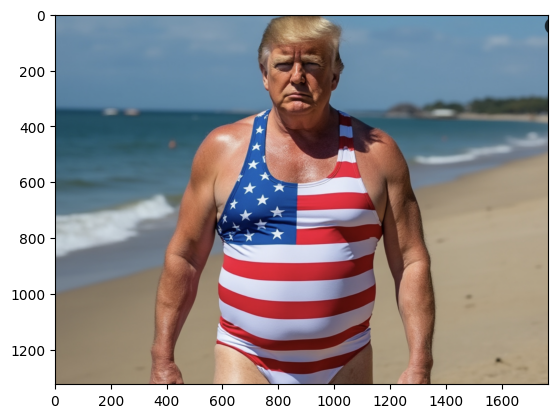

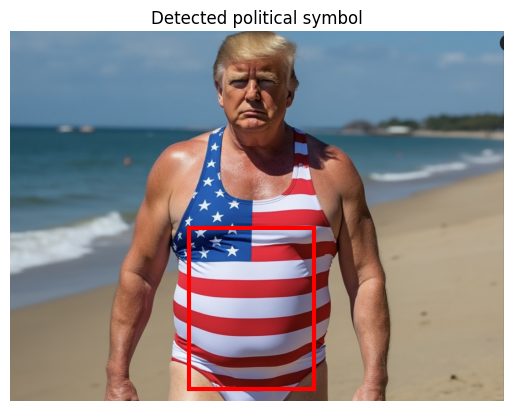

In [1]:
import os
import torch
import clip
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torchvision.transforms as T
import numpy as np

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

# Load reference symbol
ref_image = preprocess(Image.open("Unknown.jpeg")).unsqueeze(0).to(device)
with torch.no_grad():
    ref_feat = model.encode_image(ref_image)
    ref_feat /= ref_feat.norm(dim=-1, keepdim=True)

# Load target image
target_pil = Image.open("/home/vmeroni/data/images/525.png").convert("RGB")
target_image = preprocess(target_pil).unsqueeze(0).to(device)

window_size = 128
stride = 64

fig, ax = plt.subplots(1)
ax.imshow(target_pil)

W, H = target_pil.size  # Image width and height
boxes_detected = []

# Store all "good" bounding boxes
good_boxes = []

# Sliding window across the image
for y in range(0, H - window_size + 1, stride):
    for x in range(0, W - window_size + 1, stride):
        crop = target_pil.crop((x, y, x + window_size, y + window_size))
        proc_crop = preprocess(crop).unsqueeze(0).to(device)

        with torch.no_grad():
            feat = model.encode_image(proc_crop)
            feat /= feat.norm(dim=-1, keepdim=True)
            sim = (feat @ ref_feat.T).item()

        if sim > 0.85:
            good_boxes.append((x, y, x + window_size, y + window_size))

# If high-confidence boxes were found
if good_boxes:
    good_boxes = np.array(good_boxes)
    x_min = int(good_boxes[:, 0].min())
    y_min = int(good_boxes[:, 1].min())
    x_max = int(good_boxes[:, 2].max())
    y_max = int(good_boxes[:, 3].max())

    # Show image with unified bounding box
    fig, ax = plt.subplots(1)
    ax.imshow(target_pil)
    ax.add_patch(patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                                   linewidth=3, edgecolor='red', facecolor='none'))
    ax.set_title("Detected political symbol")
    plt.axis('off')
    plt.show()
else:
    print("No symbol detected with sufficient confidence.")


image 1/1 /home/vmeroni/data/images/525.png: 480x640 1 person, 43.1ms
Speed: 2.1ms preprocess, 43.1ms inference, 132.4ms postprocess per image at shape (1, 3, 480, 640)


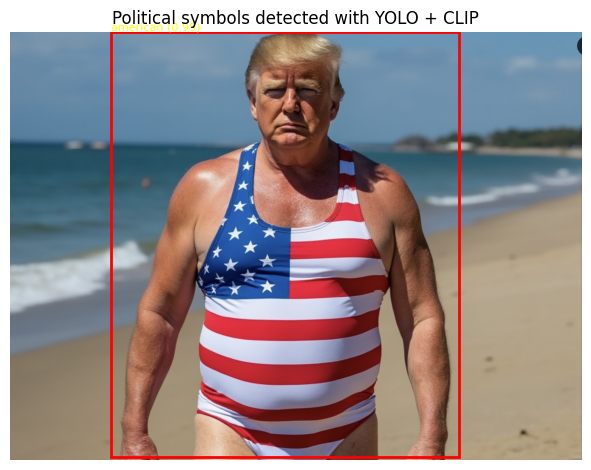


Detected symbols:
- american (conf: 0.99) at box (312, 0, 1388, 1315)


In [2]:
from ultralytics import YOLO
from PIL import Image
import torch
import clip
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# === SETUP ===
device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)

text_prompts = ["american", "political logo", "flag", "nothing important"]
text_tokens = clip.tokenize(text_prompts).to(device)
with torch.no_grad():
    text_features = clip_model.encode_text(text_tokens)
    text_features /= text_features.norm(dim=-1, keepdim=True)

# === LOAD IMAGE + YOLO ===
image_path = "/home/vmeroni/data/images/525.png"
image = Image.open(image_path).convert("RGB")
yolo_model = YOLO("yolov8n.pt")
results = yolo_model(image_path)
r = results[0]

# === DETECTION ===
fig, ax = plt.subplots(1)
ax.imshow(image)
symbols_detected = []

for box in r.boxes.xyxy:
    x1, y1, x2, y2 = map(int, box.tolist())
    cropped = image.crop((x1, y1, x2, y2))
    crop_tensor = clip_preprocess(cropped).unsqueeze(0).to(device)

    with torch.no_grad():
        image_feat = clip_model.encode_image(crop_tensor)
        image_feat /= image_feat.norm(dim=-1, keepdim=True)
        probs = (100.0 * image_feat @ text_features.T).softmax(dim=-1).squeeze()

    pred_label = text_prompts[probs.argmax()]
    confidence = probs.max().item()

    if confidence > 0.85 and pred_label != "nothing important":
        ax.add_patch(patches.Rectangle((x1, y1), x2 - x1, y2 - y1,
                     linewidth=2, edgecolor='red', facecolor='none'))
        ax.text(x1, y1 - 5, f"{pred_label} ({confidence:.2f})", color='yellow', fontsize=8)
        symbols_detected.append({
            "label": pred_label,
            "confidence": round(confidence, 2),
            "box": (x1, y1, x2, y2)
        })

plt.axis('off')
plt.title("Political symbols detected with YOLO + CLIP")
plt.tight_layout()
plt.show()

# === PRINT RESULTS ===
print("\nDetected symbols:")
if symbols_detected:
    for s in symbols_detected:
        print(f"- {s['label']} (conf: {s['confidence']}) at box {s['box']}")
else:
    print("No symbol detected.")

In [3]:
import clip
import torch
from PIL import Image  # Make sure to import this

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

# Define text prompts
text = clip.tokenize(["american", "political logo", "flag", "nothing important"]).to(device)

# Load and preprocess the image
image = preprocess(Image.open("data/images/525.png")).unsqueeze(0).to(device)

# Encode image and text, compute similarity
with torch.no_grad():
    image_features = model.encode_image(image)
    text_features = model.encode_text(text)

    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)

    probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)
    print("Probabilities:", probs)

Probabilities: tensor([[9.7656e-01, 7.4267e-05, 2.0584e-02, 2.7866e-03]], device='cuda:0', dtype=torch.float16)


In [4]:
from transformers import BlipProcessor, BlipForConditionalGeneration
from PIL import Image
import torch

# Load the BLIP VQA model (not captioning)
processor = BlipProcessor.from_pretrained("Salesforce/blip-vqa-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-vqa-base")

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

# Load and preprocess image
img = Image.open("/home/vmeroni/data/images/525.png").convert("RGB")

# Define your question
question = "Which country's flag is visible?"
inputs = processor(images=img, text=question, return_tensors="pt").to(device)
out = model.generate(**inputs)
answer = processor.decode(out[0], skip_special_tokens=True)

# Print results
print("Question:", question)
print("Answer:", answer)

E0000 00:00:1747317761.432596 2562310 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747317761.437055 2562310 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747317761.448186 2562310 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747317761.448199 2562310 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747317761.448200 2562310 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747317761.448201 2562310 computation_placer.cc:177] computation placer already registered. Please check linka

Question: Which country's flag is visible?
Answer: which country ' s flag is visible?


In [5]:
from transformers import BlipProcessor, BlipForConditionalGeneration
from PIL import Image
import torch

# Load BLIP VQA model and processor
processor = BlipProcessor.from_pretrained("Salesforce/blip-vqa-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-vqa-base")

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

# Load the image
img = Image.open("/home/vmeroni/data/images/525.png").convert("RGB")

# Define the question
question = "What flag is visible?"

# Prepare inputs and generate answer
inputs = processor(images=img, text=question, return_tensors="pt").to(device)
out = model.generate(**inputs)
answer = processor.decode(out[0], skip_special_tokens=True)

# Print question and answer
print("Question:", question)
print("Answer:", answer)

Question: What flag is visible?
Answer: what flag is visible?



image 1/1 /home/vmeroni/data/images/1061.jpeg: 480x640 2 persons, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


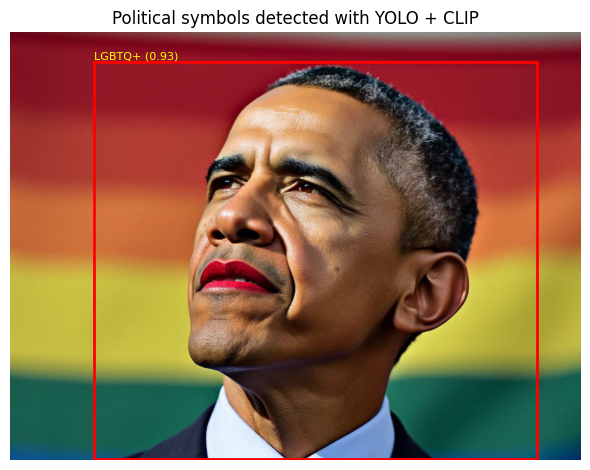


Detected symbols:
- LGBTQ+ (conf: 0.93) at box (151, 53, 946, 766)


In [12]:
from ultralytics import YOLO
from PIL import Image
import torch
import clip
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# === SETUP ===
device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)

# Define the text prompts for CLIP classification
text_prompts = ["american flag", "clown", "LGBTQ+","nothing important"]
text_tokens = clip.tokenize(text_prompts).to(device)
with torch.no_grad():
    text_features = clip_model.encode_text(text_tokens)
    text_features /= text_features.norm(dim=-1, keepdim=True)

# === LOAD IMAGE + YOLO DETECTION ===
image_path = "/home/vmeroni/data/images/1061.jpeg"
image = Image.open(image_path).convert("RGB")
yolo_model = YOLO("yolov8n.pt")
results = yolo_model(image_path)
r = results[0]

# === PROCESS DETECTIONS ===
fig, ax = plt.subplots(1)
ax.imshow(image)
symbols_detected = []

for box in r.boxes.xyxy:
    x1, y1, x2, y2 = map(int, box.tolist())
    cropped = image.crop((x1, y1, x2, y2))
    crop_tensor = clip_preprocess(cropped).unsqueeze(0).to(device)

    with torch.no_grad():
        image_feat = clip_model.encode_image(crop_tensor)
        image_feat /= image_feat.norm(dim=-1, keepdim=True)
        probs = (100.0 * image_feat @ text_features.T).softmax(dim=-1).squeeze()

    pred_label = text_prompts[probs.argmax()]
    confidence = probs.max().item()

    if confidence > 0.85 and pred_label != "nothing important":
        ax.add_patch(patches.Rectangle((x1, y1), x2 - x1, y2 - y1,
                     linewidth=2, edgecolor='red', facecolor='none'))
        ax.text(x1, y1 - 5, f"{pred_label} ({confidence:.2f})", color='yellow', fontsize=8)
        symbols_detected.append({
            "label": pred_label,
            "confidence": round(confidence, 2),
            "box": (x1, y1, x2, y2)
        })

plt.axis('off')
plt.title("Political symbols detected with YOLO + CLIP")
plt.tight_layout()
plt.show()

# === PRINT RESULTS ===
print("\nDetected symbols:")
if symbols_detected:
    for s in symbols_detected:
        print(f"- {s['label']} (conf: {s['confidence']}) at box {s['box']}")
else:
    print("No symbol detected.")


image 1/1 /home/vmeroni/data/images/441.jpeg: 480x640 7 persons, 5.0ms
Speed: 1.7ms preprocess, 5.0ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


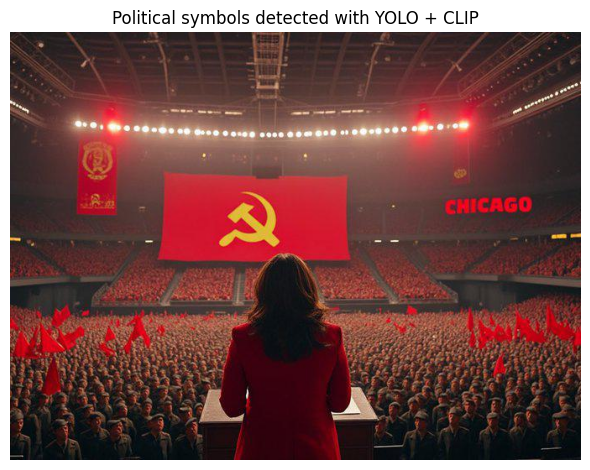


Detected symbols:
No symbol detected.


In [8]:

from ultralytics import YOLO
from PIL import Image
import torch
import clip
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# === SETUP ===
device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)

# Define the text prompts for CLIP classification
text_prompts = ["communist flag", "nothing important"]
text_tokens = clip.tokenize(text_prompts).to(device)
with torch.no_grad():
    text_features = clip_model.encode_text(text_tokens)
    text_features /= text_features.norm(dim=-1, keepdim=True)

# === LOAD IMAGE + YOLO DETECTION ===
image_path = "/home/vmeroni/data/images/441.jpeg"
image = Image.open(image_path).convert("RGB")
yolo_model = YOLO("yolov8n.pt")
results = yolo_model(image_path)
r = results[0]

# === PROCESS DETECTIONS ===
fig, ax = plt.subplots(1)
ax.imshow(image)
symbols_detected = []

for box in r.boxes.xyxy:
    x1, y1, x2, y2 = map(int, box.tolist())
    cropped = image.crop((x1, y1, x2, y2))
    crop_tensor = clip_preprocess(cropped).unsqueeze(0).to(device)

    with torch.no_grad():
        image_feat = clip_model.encode_image(crop_tensor)
        image_feat /= image_feat.norm(dim=-1, keepdim=True)
        probs = (100.0 * image_feat @ text_features.T).softmax(dim=-1).squeeze()

    pred_label = text_prompts[probs.argmax()]
    confidence = probs.max().item()

    if confidence > 0.85 and pred_label != "nothing important":
        ax.add_patch(patches.Rectangle((x1, y1), x2 - x1, y2 - y1,
                     linewidth=2, edgecolor='red', facecolor='none'))
        ax.text(x1, y1 - 5, f"{pred_label} ({confidence:.2f})", color='yellow', fontsize=8)
        symbols_detected.append({
            "label": pred_label,
            "confidence": round(confidence, 2),
            "box": (x1, y1, x2, y2)
        })

plt.axis('off')
plt.title("Political symbols detected with YOLO + CLIP")
plt.tight_layout()
plt.show()

# === PRINT RESULTS ===
print("\nDetected symbols:")
if symbols_detected:
    for s in symbols_detected:
        print(f"- {s['label']} (conf: {s['confidence']}) at box {s['box']}")
else:
    print("No symbol detected.")

In [11]:
import os
import torch
import clip
from PIL import Image
from ultralytics import YOLO
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# === SETUP ===
device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model, clip_preprocess = clip.load("ViT-L/14", device=device)
yolo_model = YOLO("yolov8n.pt")

# === LOAD REFERENCE SYMBOLS (from symbols/) ===
ref_folder = "data/simboli"
ref_paths = [os.path.join(ref_folder, f) for f in os.listdir(ref_folder)
             if f.lower().endswith((".jpg", ".png", ".jpeg"))]
ref_imgs = [clip_preprocess(Image.open(p).convert("RGB")).unsqueeze(0) for p in ref_paths]
ref_tensor = torch.cat(ref_imgs).to(device)

with torch.no_grad():
    ref_feats = clip_model.encode_image(ref_tensor)
    ref_feats /= ref_feats.norm(dim=-1, keepdim=True)

# === LOAD TARGET IMAGES (from images/) ===
target_folder = "data/images"
target_paths = [os.path.join(target_folder, f) for f in os.listdir(target_folder)
                if f.lower().endswith((".jpg", ".png", ".jpeg"))]

# === PROCESS EACH TARGET IMAGE USING YOLO + CLIP (on crops) ===
results_summary = []

for path in target_paths:
    image = Image.open(path).convert("RGB")
    results = yolo_model(path)[0]

    sim_scores = []
    for box in results.boxes.xyxy:
        x1, y1, x2, y2 = map(int, box.tolist())
        pad = 10
        x1p = max(0, x1 - pad)
        y1p = max(0, y1 - pad)
        x2p = min(image.width, x2 + pad)
        y2p = min(image.height, y2 + pad)
        crop = image.crop((x1p, y1p, x2p, y2p))
        crop_tensor = clip_preprocess(crop).unsqueeze(0).to(device)

        with torch.no_grad():
            crop_feat = clip_model.encode_image(crop_tensor)
            crop_feat /= crop_feat.norm(dim=-1, keepdim=True)
            sims = (crop_feat @ ref_feats.T).squeeze().tolist()

        sim_scores.extend(sims)

    # Aggregate similarity: mean and max
    mean_sim = max_sim = 0.0
    if sim_scores:
        mean_sim = sum(sim_scores) / len(sim_scores)
        max_sim = max(sim_scores)

    results_summary.append({
        "image": os.path.basename(path),
        "mean_similarity": round(mean_sim, 4),
        "max_similarity": round(max_sim, 4),
        "num_regions": len(sim_scores)
    })

results_summary


image 1/1 /home/vmeroni/data/images/712.png: 480x640 1 person, 1 tie, 5.0ms
Speed: 2.2ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/vmeroni/data/images/1031.jpeg: 640x640 8 persons, 5.4ms
Speed: 2.6ms preprocess, 5.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/vmeroni/data/images/859.jpeg: 640x448 (no detections), 48.6ms
Speed: 1.6ms preprocess, 48.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 448)

image 1/1 /home/vmeroni/data/images/864.jpeg: 640x640 8 persons, 1 tie, 5.0ms
Speed: 2.0ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/vmeroni/data/images/595.jpeg: 640x384 4 persons, 46.8ms
Speed: 1.8ms preprocess, 46.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

image 1/1 /home/vmeroni/data/images/994.png: 640x480 6 persons, 43.5ms
Speed: 1.6ms preprocess, 43.5ms inference, 1.0ms postprocess per 

[{'image': '712.png',
  'mean_similarity': 0.5987,
  'max_similarity': 0.6479,
  'num_regions': 10},
 {'image': '1031.jpeg',
  'mean_similarity': 0.5525,
  'max_similarity': 0.645,
  'num_regions': 40},
 {'image': '859.jpeg',
  'mean_similarity': 0.0,
  'max_similarity': 0.0,
  'num_regions': 0},
 {'image': '864.jpeg',
  'mean_similarity': 0.581,
  'max_similarity': 0.6416,
  'num_regions': 45},
 {'image': '595.jpeg',
  'mean_similarity': 0.5586,
  'max_similarity': 0.6997,
  'num_regions': 20},
 {'image': '994.png',
  'mean_similarity': 0.5519,
  'max_similarity': 0.5977,
  'num_regions': 30},
 {'image': '568.jpeg',
  'mean_similarity': 0.5449,
  'max_similarity': 0.6255,
  'num_regions': 25},
 {'image': '670.jpeg',
  'mean_similarity': 0.5982,
  'max_similarity': 0.6455,
  'num_regions': 105},
 {'image': '329.png',
  'mean_similarity': 0.4389,
  'max_similarity': 0.4861,
  'num_regions': 10},
 {'image': '175.jpeg',
  'mean_similarity': 0.6152,
  'max_similarity': 0.6455,
  'num_regio

In [13]:
import os
from ultralytics import YOLO
from PIL import Image
import torch
import clip
from tqdm import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model, clip_preprocess = clip.load("ViT-L/14", device=device)
yolo_model = YOLO("yolov8n.pt")

In [14]:
text_prompts = [
    "army",
    "prisoner",
    "american flag",
    "communist symbol",
    "police",
    "rainbow pride flag", 
    "nothing important"
]

text_tokens = clip.tokenize(text_prompts).to(device)
with torch.no_grad():
    text_features = clip_model.encode_text(text_tokens)
    text_features /= text_features.norm(dim=-1, keepdim=True)

In [30]:
image_dir = "/home/vmeroni/data/images"  
image_paths = [os.path.join(image_dir, f) for f in os.listdir(image_dir)
               if f.lower().endswith((".jpg", ".jpeg", ".png"))]

detailed_detected_data = []

for image_path in tqdm(image_paths):
    image = Image.open(image_path).convert("RGB")
    results = yolo_model(image_path)[0]

    symbol_scores = {}

    if results.boxes is not None and results.boxes.xyxy.numel() > 0:
        for box in results.boxes.xyxy:
            x1, y1, x2, y2 = map(int, box.tolist())
            cropped = image.crop((x1, y1, x2, y2))
            crop_tensor = clip_preprocess(cropped).unsqueeze(0).to(device)

            with torch.no_grad():
                image_feat = clip_model.encode_image(crop_tensor)
                image_feat /= image_feat.norm(dim=-1, keepdim=True)
                probs = (100.0 * image_feat @ text_features.T).softmax(dim=-1).squeeze()

            for idx, label in enumerate(text_prompts):
                score = probs[idx].item()
                if score > 0.9 and label != "nothing important":
                    if label in symbol_scores:
                        symbol_scores[label] = max(symbol_scores[label], score)
                    else:
                        symbol_scores[label] = score

    if symbol_scores:
        detailed_detected_data.append({
            "image": os.path.basename(image_path),
            "detected_symbols": {k: round(v, 4) for k, v in symbol_scores.items()}
        })

  0%|                                                                                                                | 0/624 [00:00<?, ?it/s]


image 1/1 /home/vmeroni/data/images/712.png: 480x640 1 person, 1 tie, 7.3ms
Speed: 2.0ms preprocess, 7.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


  0%|▏                                                                                                       | 1/624 [00:00<01:16,  8.16it/s]


image 1/1 /home/vmeroni/data/images/1031.jpeg: 640x640 8 persons, 6.7ms
Speed: 2.6ms preprocess, 6.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


  0%|▎                                                                                                       | 2/624 [00:00<02:01,  5.12it/s]


image 1/1 /home/vmeroni/data/images/859.jpeg: 640x448 (no detections), 6.6ms
Speed: 1.6ms preprocess, 6.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 448)

image 1/1 /home/vmeroni/data/images/864.jpeg: 640x640 8 persons, 1 tie, 6.3ms
Speed: 2.0ms preprocess, 6.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


  1%|▋                                                                                                       | 4/624 [00:00<01:34,  6.54it/s]


image 1/1 /home/vmeroni/data/images/595.jpeg: 640x384 4 persons, 7.0ms
Speed: 1.7ms preprocess, 7.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


  1%|▊                                                                                                       | 5/624 [00:00<01:34,  6.53it/s]


image 1/1 /home/vmeroni/data/images/994.png: 640x480 6 persons, 6.5ms
Speed: 1.6ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


  1%|█                                                                                                       | 6/624 [00:00<01:40,  6.13it/s]


image 1/1 /home/vmeroni/data/images/568.jpeg: 512x640 3 persons, 1 car, 1 dog, 6.3ms
Speed: 1.6ms preprocess, 6.3ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


  1%|█▏                                                                                                      | 7/624 [00:01<01:35,  6.49it/s]


image 1/1 /home/vmeroni/data/images/670.jpeg: 480x640 20 persons, 1 kite, 6.6ms
Speed: 2.0ms preprocess, 6.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


  1%|█▎                                                                                                      | 8/624 [00:01<02:51,  3.59it/s]


image 1/1 /home/vmeroni/data/images/329.png: 640x640 2 persons, 6.6ms
Speed: 2.4ms preprocess, 6.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


  1%|█▌                                                                                                      | 9/624 [00:01<02:23,  4.28it/s]


image 1/1 /home/vmeroni/data/images/175.jpeg: 640x640 2 persons, 5.8ms
Speed: 2.1ms preprocess, 5.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/vmeroni/data/images/616.jpeg: 640x448 1 person, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)


  2%|█▊                                                                                                     | 11/624 [00:01<01:33,  6.54it/s]


image 1/1 /home/vmeroni/data/images/148.jpeg: 640x640 1 person, 1 tie, 1 chair, 1 bed, 6.3ms
Speed: 2.4ms preprocess, 6.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


  2%|█▉                                                                                                     | 12/624 [00:02<01:29,  6.83it/s]


image 1/1 /home/vmeroni/data/images/985.jpeg: 480x640 1 person, 1 cup, 1 sandwich, 1 hot dog, 6.3ms
Speed: 1.6ms preprocess, 6.3ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


  2%|██▏                                                                                                    | 13/624 [00:02<01:24,  7.25it/s]


image 1/1 /home/vmeroni/data/images/326.png: 640x544 3 persons, 6.4ms
Speed: 2.2ms preprocess, 6.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 544)


  2%|██▎                                                                                                    | 14/624 [00:02<01:22,  7.36it/s]


image 1/1 /home/vmeroni/data/images/1028.jpeg: 512x640 1 person, 2 bottles, 1 cup, 6.2ms
Speed: 1.7ms preprocess, 6.2ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


  2%|██▍                                                                                                    | 15/624 [00:02<01:19,  7.70it/s]


image 1/1 /home/vmeroni/data/images/180.jpeg: 640x640 12 persons, 2 ties, 2 chairs, 1 book, 6.2ms
Speed: 2.0ms preprocess, 6.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


  3%|██▋                                                                                                    | 16/624 [00:02<02:12,  4.59it/s]


image 1/1 /home/vmeroni/data/images/759.jpeg: 640x640 16 persons, 6.2ms
Speed: 2.6ms preprocess, 6.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


  3%|██▊                                                                                                    | 17/624 [00:03<02:52,  3.52it/s]


image 1/1 /home/vmeroni/data/images/704.png: 640x640 8 persons, 6.0ms
Speed: 2.3ms preprocess, 6.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


  3%|██▉                                                                                                    | 18/624 [00:03<02:47,  3.62it/s]


image 1/1 /home/vmeroni/data/images/153.jpeg: 640x640 1 person, 1 laptop, 6.0ms
Speed: 2.3ms preprocess, 6.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/vmeroni/data/images/323.png: 640x576 4 persons, 6.5ms
Speed: 2.3ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 576)


  3%|███▎                                                                                                   | 20/624 [00:03<02:02,  4.93it/s]


image 1/1 /home/vmeroni/data/images/545.png: 448x640 12 persons, 2 cell phones, 6.4ms
Speed: 1.6ms preprocess, 6.4ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


  3%|███▍                                                                                                   | 21/624 [00:04<02:26,  4.11it/s]


image 1/1 /home/vmeroni/data/images/963.jpeg: 480x640 1 person, 1 tie, 6.2ms
Speed: 1.7ms preprocess, 6.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/vmeroni/data/images/764.jpeg: 640x480 2 persons, 1 bed, 6.7ms
Speed: 2.2ms preprocess, 6.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


  4%|███▊                                                                                                   | 23/624 [00:04<01:54,  5.24it/s]


image 1/1 /home/vmeroni/data/images/1023.jpeg: 480x640 4 persons, 1 tie, 1 sandwich, 1 pizza, 6.6ms
Speed: 1.7ms preprocess, 6.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


  4%|███▉                                                                                                   | 24/624 [00:04<01:58,  5.08it/s]


image 1/1 /home/vmeroni/data/images/495.jpeg: 480x640 2 persons, 6.2ms
Speed: 1.6ms preprocess, 6.2ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/vmeroni/data/images/701.png: 640x512 1 person, 1 tie, 1 couch, 8.2ms
Speed: 2.5ms preprocess, 8.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 512)


  4%|████▎                                                                                                  | 26/624 [00:04<01:45,  5.69it/s]


image 1/1 /home/vmeroni/data/images/737.jpeg: 480x640 2 persons, 1 tie, 1 frisbee, 3 kites, 8.3ms
Speed: 2.0ms preprocess, 8.3ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


  4%|████▍                                                                                                  | 27/624 [00:05<01:47,  5.57it/s]


image 1/1 /home/vmeroni/data/images/538.jpeg: 608x640 4 persons, 6.6ms
Speed: 2.0ms preprocess, 6.6ms inference, 1.0ms postprocess per image at shape (1, 3, 608, 640)


  4%|████▌                                                                                                  | 28/624 [00:05<01:37,  6.12it/s]


image 1/1 /home/vmeroni/data/images/320.png: 640x544 2 persons, 1 tie, 1 bottle, 6.5ms
Speed: 2.3ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 544)


  5%|████▊                                                                                                  | 29/624 [00:05<01:36,  6.14it/s]


image 1/1 /home/vmeroni/data/images/383.png: 480x640 3 persons, 6.4ms
Speed: 1.9ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


  5%|████▉                                                                                                  | 30/624 [00:05<01:34,  6.31it/s]


image 1/1 /home/vmeroni/data/images/380.png: 608x640 1 person, 6.6ms
Speed: 2.6ms preprocess, 6.6ms inference, 1.0ms postprocess per image at shape (1, 3, 608, 640)


  5%|█████                                                                                                  | 31/624 [00:05<01:30,  6.58it/s]


image 1/1 /home/vmeroni/data/images/686.jpeg: 640x512 3 persons, 1 chair, 6.4ms
Speed: 2.1ms preprocess, 6.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 512)


  5%|█████▎                                                                                                 | 32/624 [00:05<01:27,  6.79it/s]


image 1/1 /home/vmeroni/data/images/858.jpeg: 480x640 11 persons, 6.4ms
Speed: 1.7ms preprocess, 6.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


  5%|█████▍                                                                                                 | 33/624 [00:06<01:50,  5.35it/s]


image 1/1 /home/vmeroni/data/images/844_2.jpeg: 480x640 2 persons, 1 cup, 1 bowl, 1 chair, 1 dining table, 5.9ms
Speed: 1.5ms preprocess, 5.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


  5%|█████▌                                                                                                 | 34/624 [00:06<01:46,  5.55it/s]


image 1/1 /home/vmeroni/data/images/123.jpeg: 384x640 3 persons, 1 tie, 6.5ms
Speed: 1.6ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


  6%|█████▊                                                                                                 | 35/624 [00:06<01:37,  6.06it/s]


image 1/1 /home/vmeroni/data/images/691.jpeg: 608x640 2 persons, 2 ties, 6.3ms
Speed: 2.1ms preprocess, 6.3ms inference, 1.0ms postprocess per image at shape (1, 3, 608, 640)


  6%|█████▉                                                                                                 | 36/624 [00:06<01:28,  6.64it/s]


image 1/1 /home/vmeroni/data/images/863.jpeg: 480x640 1 person, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/vmeroni/data/images/933.jpeg: 512x640 3 persons, 1 tie, 6.6ms
Speed: 2.0ms preprocess, 6.6ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)


  6%|██████▎                                                                                                | 38/624 [00:06<01:11,  8.21it/s]


image 1/1 /home/vmeroni/data/images/537.png: 448x640 1 person, 1 airplane, 6.5ms
Speed: 1.6ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 /home/vmeroni/data/images/664.jpeg: 480x640 1 person, 2 ties, 1 carrot, 6.2ms
Speed: 1.8ms preprocess, 6.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


  6%|██████▌                                                                                                | 40/624 [00:06<01:06,  8.76it/s]


image 1/1 /home/vmeroni/data/images/906.jpeg: 480x640 7 persons, 6.1ms
Speed: 1.6ms preprocess, 6.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


  7%|██████▊                                                                                                | 41/624 [00:07<01:14,  7.78it/s]


image 1/1 /home/vmeroni/data/images/378.png: 640x640 3 persons, 2 ties, 6.5ms
Speed: 2.5ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


  7%|██████▉                                                                                                | 42/624 [00:07<01:31,  6.39it/s]


image 1/1 /home/vmeroni/data/images/640.png: 640x512 1 person, 6.6ms
Speed: 2.1ms preprocess, 6.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 512)


  7%|███████                                                                                                | 43/624 [00:07<01:25,  6.81it/s]


image 1/1 /home/vmeroni/data/images/169.jpeg: 640x640 12 persons, 4 ties, 3 bottles, 1 dining table, 6.3ms
Speed: 2.0ms preprocess, 6.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


  7%|███████▎                                                                                               | 44/624 [00:07<02:19,  4.15it/s]


image 1/1 /home/vmeroni/data/images/979.jpeg: 480x640 11 persons, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


  7%|███████▍                                                                                               | 45/624 [00:08<02:26,  3.95it/s]


image 1/1 /home/vmeroni/data/images/1060.jpeg: 480x640 6 persons, 6.0ms
Speed: 1.7ms preprocess, 6.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


  7%|███████▌                                                                                               | 46/624 [00:08<02:13,  4.33it/s]


image 1/1 /home/vmeroni/data/images/911.jpeg: 640x320 1 person, 6.8ms
Speed: 1.5ms preprocess, 6.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 320)

image 1/1 /home/vmeroni/data/images/375.png: 480x640 2 persons, 1 tie, 6.5ms
Speed: 1.9ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


  8%|███████▉                                                                                               | 48/624 [00:08<01:41,  5.68it/s]


image 1/1 /home/vmeroni/data/images/174.jpeg: 640x640 3 persons, 4 wine glasss, 6.4ms
Speed: 2.3ms preprocess, 6.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


  8%|████████                                                                                               | 49/624 [00:08<01:43,  5.53it/s]


image 1/1 /home/vmeroni/data/images/984.jpeg: 480x640 2 persons, 1 cup, 1 bowl, 1 chair, 1 dining table, 6.5ms
Speed: 1.6ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


  8%|████████▎                                                                                              | 50/624 [00:08<01:41,  5.65it/s]


image 1/1 /home/vmeroni/data/images/1009.png: 608x640 1 person, 6.4ms
Speed: 2.6ms preprocess, 6.4ms inference, 1.0ms postprocess per image at shape (1, 3, 608, 640)


  8%|████████▍                                                                                              | 51/624 [00:09<01:30,  6.33it/s]


image 1/1 /home/vmeroni/data/images/586.jpeg: 480x640 2 persons, 1 tie, 6.5ms
Speed: 1.0ms preprocess, 6.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/vmeroni/data/images/758.jpeg: 512x640 1 person, 6.6ms
Speed: 2.2ms preprocess, 6.6ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)


  8%|████████▋                                                                                              | 53/624 [00:09<01:10,  8.08it/s]


image 1/1 /home/vmeroni/data/images/416.png: 640x640 6 persons, 1 tv, 6.4ms
Speed: 2.1ms preprocess, 6.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


  9%|████████▉                                                                                              | 54/624 [00:09<01:23,  6.84it/s]


image 1/1 /home/vmeroni/data/images/638.png: 480x640 10 persons, 1 tie, 6.3ms
Speed: 1.7ms preprocess, 6.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


  9%|█████████                                                                                              | 55/624 [00:09<01:48,  5.23it/s]


image 1/1 /home/vmeroni/data/images/479.png: 480x640 2 persons, 6.1ms
Speed: 2.0ms preprocess, 6.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


  9%|█████████▏                                                                                             | 56/624 [00:09<01:42,  5.53it/s]


image 1/1 /home/vmeroni/data/images/591.jpeg: 640x640 1 person, 1 cell phone, 1 clock, 6.6ms
Speed: 2.6ms preprocess, 6.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


  9%|█████████▍                                                                                             | 57/624 [00:09<01:33,  6.10it/s]


image 1/1 /home/vmeroni/data/images/413.png: 640x640 2 persons, 1 book, 6.2ms
Speed: 2.6ms preprocess, 6.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


  9%|█████████▌                                                                                             | 58/624 [00:10<01:46,  5.31it/s]


image 1/1 /home/vmeroni/data/images/635.png: 512x640 4 persons, 6.4ms
Speed: 1.9ms preprocess, 6.4ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)


  9%|█████████▋                                                                                             | 59/624 [00:10<01:41,  5.57it/s]


image 1/1 /home/vmeroni/data/images/1015.jpeg: 480x640 2 persons, 6.4ms
Speed: 1.7ms preprocess, 6.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/vmeroni/data/images/806.jpeg: 640x480 4 persons, 1 tie, 6.7ms
Speed: 2.1ms preprocess, 6.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 480)


 10%|██████████                                                                                             | 61/624 [00:10<01:25,  6.56it/s]


image 1/1 /home/vmeroni/data/images/307.png: 640x640 3 persons, 6.4ms
Speed: 2.5ms preprocess, 6.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


 10%|██████████▏                                                                                            | 62/624 [00:10<01:23,  6.72it/s]


image 1/1 /home/vmeroni/data/images/476.png: 480x640 11 persons, 3 ties, 1 laptop, 6.3ms
Speed: 1.6ms preprocess, 6.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


 10%|██████████▍                                                                                            | 63/624 [00:11<02:01,  4.61it/s]


image 1/1 /home/vmeroni/data/images/139.jpeg: 640x640 8 persons, 1 traffic light, 1 tie, 6.4ms
Speed: 2.3ms preprocess, 6.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


 10%|██████████▌                                                                                            | 64/624 [00:11<02:10,  4.28it/s]


image 1/1 /home/vmeroni/data/images/410.png: 640x640 7 persons, 2 ties, 6.2ms
Speed: 2.1ms preprocess, 6.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


 10%|██████████▋                                                                                            | 65/624 [00:11<02:27,  3.80it/s]


image 1/1 /home/vmeroni/data/images/632.png: 512x640 12 persons, 6.5ms
Speed: 2.0ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)


 11%|██████████▉                                                                                            | 66/624 [00:12<02:44,  3.40it/s]


image 1/1 /home/vmeroni/data/images/473.png: 448x640 1 person, 1 cat, 1 tie, 6.4ms
Speed: 1.6ms preprocess, 6.4ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 11%|███████████                                                                                            | 67/624 [00:12<02:16,  4.09it/s]


image 1/1 /home/vmeroni/data/images/612.jpeg: 640x640 1 person, 1 tie, 1 clock, 6.2ms
Speed: 2.1ms preprocess, 6.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/vmeroni/data/images/144.jpeg: 640x640 9 persons, 1 tie, 6.0ms
Speed: 2.3ms preprocess, 6.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


 11%|███████████▍                                                                                           | 69/624 [00:12<01:59,  4.63it/s]


image 1/1 /home/vmeroni/data/images/685.jpeg: 480x640 1 person, 1 sandwich, 1 hot dog, 6.5ms
Speed: 1.6ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/vmeroni/data/images/486.jpeg: 640x512 3 persons, 6.3ms
Speed: 1.9ms preprocess, 6.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)


 11%|███████████▋                                                                                           | 71/624 [00:12<01:32,  5.96it/s]


image 1/1 /home/vmeroni/data/images/927.jpeg: 640x576 2 persons, 6.6ms
Speed: 2.3ms preprocess, 6.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 576)

image 1/1 /home/vmeroni/data/images/728.jpeg: 480x640 6 persons, 6.7ms
Speed: 2.0ms preprocess, 6.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


 12%|████████████                                                                                           | 73/624 [00:13<01:24,  6.49it/s]


image 1/1 /home/vmeroni/data/images/869_1.jpeg: 480x640 12 persons, 1 tie, 6.0ms
Speed: 1.7ms preprocess, 6.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


 12%|████████████▏                                                                                          | 74/624 [00:13<01:45,  5.22it/s]


image 1/1 /home/vmeroni/data/images/122.jpeg: 384x640 7 persons, 1 tennis racket, 6.5ms
Speed: 1.6ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


 12%|████████████▍                                                                                          | 75/624 [00:13<01:49,  5.00it/s]


image 1/1 /home/vmeroni/data/images/577.png: 480x640 1 person, 1 wine glass, 1 chair, 1 dining table, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


 12%|████████████▌                                                                                          | 76/624 [00:13<01:44,  5.23it/s]


image 1/1 /home/vmeroni/data/images/1044.jpeg: 640x640 9 persons, 6.4ms
Speed: 2.3ms preprocess, 6.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


 12%|████████████▋                                                                                          | 77/624 [00:14<01:50,  4.93it/s]


image 1/1 /home/vmeroni/data/images/932.jpeg: 640x640 4 persons, 2 ties, 6.1ms
Speed: 2.4ms preprocess, 6.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


 12%|████████████▉                                                                                          | 78/624 [00:14<01:47,  5.08it/s]


image 1/1 /home/vmeroni/data/images/733.jpeg: 544x640 9 persons, 2 cups, 3 chairs, 6.8ms
Speed: 2.4ms preprocess, 6.8ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)


 13%|█████████████                                                                                          | 79/624 [00:14<02:13,  4.08it/s]


image 1/1 /home/vmeroni/data/images/905.jpeg: 480x640 1 person, 1 potted plant, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/vmeroni/data/images/265.jpeg: 640x640 1 person, 6.5ms
Speed: 2.3ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


 13%|█████████████▎                                                                                         | 81/624 [00:14<01:29,  6.09it/s]


image 1/1 /home/vmeroni/data/images/706.jpeg: 640x640 2 persons, 2 ties, 1 potted plant, 3 books, 1 vase, 6.3ms
Speed: 2.6ms preprocess, 6.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


 13%|█████████████▌                                                                                         | 82/624 [00:15<01:41,  5.32it/s]


image 1/1 /home/vmeroni/data/images/405.png: 544x640 17 persons, 4 ties, 6.5ms
Speed: 2.2ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)


 13%|█████████████▋                                                                                         | 83/624 [00:15<02:36,  3.46it/s]


image 1/1 /home/vmeroni/data/images/627.png: 480x640 7 persons, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


 13%|█████████████▊                                                                                         | 84/624 [00:15<02:27,  3.67it/s]


image 1/1 /home/vmeroni/data/images/574.png: 480x640 2 persons, 6.0ms
Speed: 1.7ms preprocess, 6.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


 14%|██████████████                                                                                         | 85/624 [00:15<02:03,  4.37it/s]


image 1/1 /home/vmeroni/data/images/952.png: 640x640 2 persons, 1 tie, 6.4ms
Speed: 2.3ms preprocess, 6.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


 14%|██████████████▏                                                                                        | 86/624 [00:16<01:52,  4.79it/s]


image 1/1 /home/vmeroni/data/images/1036.jpeg: 480x640 1 person, 6.6ms
Speed: 2.1ms preprocess, 6.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/vmeroni/data/images/849.jpeg: 448x640 2 persons, 1 tie, 6.4ms
Speed: 1.7ms preprocess, 6.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


 14%|██████████████▌                                                                                        | 88/624 [00:16<01:20,  6.62it/s]


image 1/1 /home/vmeroni/data/images/571.png: 512x640 4 persons, 6.5ms
Speed: 1.9ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)


 14%|██████████████▋                                                                                        | 89/624 [00:16<01:23,  6.44it/s]


image 1/1 /home/vmeroni/data/images/854.jpeg: 480x640 1 person, 1 boat, 2 birds, 1 tie, 6.6ms
Speed: 1.5ms preprocess, 6.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


 14%|██████████████▊                                                                                        | 90/624 [00:16<01:20,  6.65it/s]


image 1/1 /home/vmeroni/data/images/827.jpeg: 480x640 3 persons, 1 dog, 6.0ms
Speed: 1.5ms preprocess, 6.0ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


 15%|███████████████                                                                                        | 91/624 [00:16<01:14,  7.14it/s]


image 1/1 /home/vmeroni/data/images/628.jpeg: 608x640 1 person, 6.6ms
Speed: 2.5ms preprocess, 6.6ms inference, 1.0ms postprocess per image at shape (1, 3, 608, 640)

image 1/1 /home/vmeroni/data/images/590.jpeg: 480x640 1 person, 6.9ms
Speed: 2.2ms preprocess, 6.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


 15%|███████████████▎                                                                                       | 93/624 [00:16<00:57,  9.24it/s]


image 1/1 /home/vmeroni/data/images/569.png: 480x640 8 persons, 1 cell phone, 6.0ms
Speed: 1.7ms preprocess, 6.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/vmeroni/data/images/165.jpeg: 640x640 1 person, 6.4ms
Speed: 2.3ms preprocess, 6.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


 15%|███████████████▋                                                                                       | 95/624 [00:17<01:09,  7.65it/s]


image 1/1 /home/vmeroni/data/images/947.png: 512x640 3 persons, 3 ties, 1 chair, 1 tv, 3 laptops, 6.4ms
Speed: 1.9ms preprocess, 6.4ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)


 15%|███████████████▊                                                                                       | 96/624 [00:17<01:31,  5.75it/s]


image 1/1 /home/vmeroni/data/images/606.jpeg: 480x640 13 persons, 6.4ms
Speed: 1.5ms preprocess, 6.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


 16%|████████████████                                                                                       | 97/624 [00:17<01:49,  4.79it/s]


image 1/1 /home/vmeroni/data/images/138.jpeg: 640x640 12 persons, 6.7ms
Speed: 2.8ms preprocess, 6.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


 16%|████████████████▏                                                                                      | 98/624 [00:18<02:04,  4.22it/s]


image 1/1 /home/vmeroni/data/images/566.png: 480x640 7 persons, 6.4ms
Speed: 1.7ms preprocess, 6.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


 16%|████████████████▎                                                                                      | 99/624 [00:18<02:04,  4.23it/s]


image 1/1 /home/vmeroni/data/images/788.png: 480x640 1 person, 6.0ms
Speed: 1.7ms preprocess, 6.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/vmeroni/data/images/975.jpeg: 512x640 3 persons, 1 cell phone, 6.4ms
Speed: 1.9ms preprocess, 6.4ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


 16%|████████████████▌                                                                                     | 101/624 [00:18<01:32,  5.64it/s]


image 1/1 /home/vmeroni/data/images/185.png: 640x544 7 persons, 1 handbag, 1 tie, 6.4ms
Speed: 2.2ms preprocess, 6.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 544)


 16%|████████████████▋                                                                                     | 102/624 [00:18<01:48,  4.81it/s]


image 1/1 /home/vmeroni/data/images/944.png: 640x576 1 person, 1 pizza, 6.2ms
Speed: 1.8ms preprocess, 6.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 576)

image 1/1 /home/vmeroni/data/images/170.jpeg: 640x640 10 persons, 3 ties, 1 bottle, 1 laptop, 6.1ms
Speed: 2.0ms preprocess, 6.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


 17%|█████████████████                                                                                     | 104/624 [00:19<01:52,  4.64it/s]


image 1/1 /home/vmeroni/data/images/749.jpeg: 640x608 1 person, 1 tie, 6.4ms
Speed: 2.1ms preprocess, 6.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 608)

image 1/1 /home/vmeroni/data/images/611.jpeg: 480x640 3 persons, 3 ties, 6.3ms
Speed: 1.7ms preprocess, 6.3ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


 17%|█████████████████▎                                                                                    | 106/624 [00:19<01:33,  5.54it/s]


image 1/1 /home/vmeroni/data/images/1033.jpeg: 480x640 10 persons, 1 tie, 1 frisbee, 1 sports ball, 6.5ms
Speed: 2.0ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


 17%|█████████████████▍                                                                                    | 107/624 [00:19<01:53,  4.56it/s]


image 1/1 /home/vmeroni/data/images/143.jpeg: 640x640 7 persons, 1 tie, 6.5ms
Speed: 2.3ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


 17%|█████████████████▋                                                                                    | 108/624 [00:20<01:54,  4.49it/s]


image 1/1 /home/vmeroni/data/images/785.png: 512x640 1 person, 1 tie, 6.5ms
Speed: 2.0ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)


 17%|█████████████████▊                                                                                    | 109/624 [00:20<01:40,  5.12it/s]


image 1/1 /home/vmeroni/data/images/980.jpeg: 640x640 2 persons, 6.2ms
Speed: 2.0ms preprocess, 6.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/vmeroni/data/images/1053.jpeg: 480x640 1 person, 4 cats, 1 tie, 1 banana, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


 18%|██████████████████▏                                                                                   | 111/624 [00:20<01:26,  5.93it/s]


image 1/1 /home/vmeroni/data/images/754.jpeg: 640x480 1 person, 1 apple, 1 orange, 6.7ms
Speed: 2.2ms preprocess, 6.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


 18%|██████████████████▎                                                                                   | 112/624 [00:20<01:19,  6.46it/s]


image 1/1 /home/vmeroni/data/images/485.jpeg: 480x640 1 person, 1 tie, 6.4ms
Speed: 1.6ms preprocess, 6.4ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/vmeroni/data/images/555.jpeg: 480x640 2 persons, 2 cars, 1 tie, 6.2ms
Speed: 2.0ms preprocess, 6.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


 18%|██████████████████▋                                                                                   | 114/624 [00:20<01:11,  7.17it/s]


image 1/1 /home/vmeroni/data/images/782.png: 480x640 1 person, 6.3ms
Speed: 2.1ms preprocess, 6.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


 18%|██████████████████▊                                                                                   | 115/624 [00:21<01:12,  7.01it/s]


image 1/1 /home/vmeroni/data/images/727.jpeg: 480x640 7 persons, 1 kite, 3 chairs, 6.2ms
Speed: 2.1ms preprocess, 6.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


 19%|██████████████████▉                                                                                   | 116/624 [00:21<01:31,  5.57it/s]


image 1/1 /home/vmeroni/data/images/732.jpeg: 480x640 11 persons, 1 tie, 1 skis, 6.2ms
Speed: 2.0ms preprocess, 6.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


 19%|███████████████████▏                                                                                  | 117/624 [00:21<01:53,  4.47it/s]


image 1/1 /home/vmeroni/data/images/533.jpeg: 640x512 3 persons, 1 chair, 6.5ms
Speed: 2.1ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 512)


 19%|███████████████████▎                                                                                  | 118/624 [00:21<01:41,  4.99it/s]


image 1/1 /home/vmeroni/data/images/506.jpeg: 640x512 21 persons, 6.4ms
Speed: 2.3ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 512)


 19%|███████████████████▍                                                                                  | 119/624 [00:22<02:29,  3.37it/s]


image 1/1 /home/vmeroni/data/images/1017.jpeg: 480x640 1 person, 1 tie, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/vmeroni/data/images/717.png: 640x640 8 persons, 1 train, 6.4ms
Speed: 2.3ms preprocess, 6.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


 19%|███████████████████▊                                                                                  | 121/624 [00:22<02:02,  4.09it/s]


image 1/1 /home/vmeroni/data/images/939.png: 480x640 1 person, 2 boats, 2 birds, 1 cat, 1 dog, 1 tie, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


 20%|███████████████████▉                                                                                  | 122/624 [00:22<02:04,  4.05it/s]


image 1/1 /home/vmeroni/data/images/676.jpeg: 480x640 1 person, 1 tie, 6.1ms
Speed: 1.6ms preprocess, 6.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/vmeroni/data/images/848.jpeg: 480x640 1 person, 2 horses, 5.9ms
Speed: 1.7ms preprocess, 5.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


 20%|████████████████████▎                                                                                 | 124/624 [00:23<01:30,  5.52it/s]


image 1/1 /home/vmeroni/data/images/1040.jpeg: 480x640 2 persons, 6.2ms
Speed: 2.0ms preprocess, 6.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/vmeroni/data/images/511.jpeg: 640x512 1 person, 1 airplane, 6.5ms
Speed: 2.0ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 512)


 20%|████████████████████▌                                                                                 | 126/624 [00:23<01:12,  6.86it/s]


image 1/1 /home/vmeroni/data/images/714.png: 512x640 5 persons, 6.4ms
Speed: 1.9ms preprocess, 6.4ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)


 20%|████████████████████▊                                                                                 | 127/624 [00:23<01:16,  6.52it/s]


image 1/1 /home/vmeroni/data/images/880.jpeg: 640x640 4 persons, 1 tie, 2 beds, 6.5ms
Speed: 2.3ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


 21%|████████████████████▉                                                                                 | 128/624 [00:23<01:22,  6.00it/s]


image 1/1 /home/vmeroni/data/images/1004.jpeg: 640x640 2 persons, 1 skateboard, 6.0ms
Speed: 2.3ms preprocess, 6.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


 21%|█████████████████████                                                                                 | 129/624 [00:23<01:14,  6.61it/s]


image 1/1 /home/vmeroni/data/images/777.png: 480x640 1 person, 1 potted plant, 1 dining table, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


 21%|█████████████████████▎                                                                                | 130/624 [00:23<01:13,  6.76it/s]


image 1/1 /home/vmeroni/data/images/711.png: 480x640 2 persons, 1 tie, 1 cup, 1 teddy bear, 6.0ms
Speed: 1.7ms preprocess, 6.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


 21%|█████████████████████▍                                                                                | 131/624 [00:24<01:18,  6.32it/s]


image 1/1 /home/vmeroni/data/images/455.jpeg: 480x640 8 persons, 2 ties, 1 laptop, 6.2ms
Speed: 1.9ms preprocess, 6.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


 21%|█████████████████████▌                                                                                | 132/624 [00:24<01:36,  5.12it/s]


image 1/1 /home/vmeroni/data/images/159.jpeg: 640x640 4 persons, 1 book, 6.5ms
Speed: 2.3ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


 21%|█████████████████████▋                                                                                | 133/624 [00:24<01:30,  5.44it/s]


image 1/1 /home/vmeroni/data/images/330.png: 640x480 4 persons, 1 tv, 6.6ms
Speed: 2.0ms preprocess, 6.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


 21%|█████████████████████▉                                                                                | 134/624 [00:24<01:31,  5.36it/s]


image 1/1 /home/vmeroni/data/images/969.jpeg: 480x640 9 persons, 6.3ms
Speed: 1.7ms preprocess, 6.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


 22%|██████████████████████                                                                                | 135/624 [00:25<01:39,  4.94it/s]


image 1/1 /home/vmeroni/data/images/901.jpeg: 640x640 8 persons, 6.3ms
Speed: 2.2ms preprocess, 6.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


 22%|██████████████████████▏                                                                               | 136/624 [00:25<01:39,  4.88it/s]


image 1/1 /home/vmeroni/data/images/1030.png: 480x640 2 persons, 1 sports ball, 7.1ms
Speed: 1.9ms preprocess, 7.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


 22%|██████████████████████▍                                                                               | 137/624 [00:25<01:31,  5.30it/s]


image 1/1 /home/vmeroni/data/images/659.png: 640x608 1 person, 2 pizzas, 1 dining table, 6.5ms
Speed: 2.0ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 608)


 22%|██████████████████████▌                                                                               | 138/624 [00:25<01:23,  5.80it/s]


image 1/1 /home/vmeroni/data/images/656.png: 480x640 1 person, 6.5ms
Speed: 2.0ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


 22%|██████████████████████▋                                                                               | 139/624 [00:25<01:14,  6.54it/s]


image 1/1 /home/vmeroni/data/images/748.jpeg: 480x640 1 person, 1 baseball bat, 5.9ms
Speed: 1.5ms preprocess, 5.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/vmeroni/data/images/818.jpeg: 640x640 13 persons, 3 ties, 6.5ms
Speed: 2.4ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


 23%|███████████████████████                                                                               | 141/624 [00:26<01:35,  5.06it/s]


image 1/1 /home/vmeroni/data/images/549.jpeg: 640x640 1 person, 2 cars, 6.4ms
Speed: 2.6ms preprocess, 6.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


 23%|███████████████████████▏                                                                              | 142/624 [00:26<01:25,  5.63it/s]


image 1/1 /home/vmeroni/data/images/328.png: 640x544 17 persons, 6.7ms
Speed: 2.3ms preprocess, 6.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 544)


 23%|███████████████████████▍                                                                              | 143/624 [00:26<02:02,  3.93it/s]


image 1/1 /home/vmeroni/data/images/212.jpeg: 640x640 3 persons, 1 tie, 7.0ms
Speed: 2.2ms preprocess, 7.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


 23%|███████████████████████▌                                                                              | 144/624 [00:26<01:44,  4.59it/s]


image 1/1 /home/vmeroni/data/images/653.png: 512x640 11 persons, 6.4ms
Speed: 1.9ms preprocess, 6.4ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)


 23%|███████████████████████▋                                                                              | 145/624 [00:27<01:57,  4.07it/s]


image 1/1 /home/vmeroni/data/images/554.jpeg: 640x576 6 persons, 1 tie, 3 cups, 6.6ms
Speed: 2.4ms preprocess, 6.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 576)


 23%|███████████████████████▊                                                                              | 146/624 [00:27<02:09,  3.68it/s]


image 1/1 /home/vmeroni/data/images/325.png: 640x544 4 persons, 1 car, 7.2ms
Speed: 2.5ms preprocess, 7.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 544)


 24%|████████████████████████                                                                              | 147/624 [00:27<01:59,  3.98it/s]


image 1/1 /home/vmeroni/data/images/703.png: 512x640 1 person, 7.5ms
Speed: 2.1ms preprocess, 7.5ms inference, 1.2ms postprocess per image at shape (1, 3, 512, 640)

image 1/1 /home/vmeroni/data/images/129.jpeg: 640x640 4 persons, 1 handbag, 6.4ms
Speed: 2.4ms preprocess, 6.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


 24%|████████████████████████▎                                                                             | 149/624 [00:27<01:32,  5.11it/s]


image 1/1 /home/vmeroni/data/images/697.jpeg: 480x640 8 persons, 1 cup, 1 cell phone, 6.5ms
Speed: 1.6ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


 24%|████████████████████████▌                                                                             | 150/624 [00:28<01:41,  4.65it/s]


image 1/1 /home/vmeroni/data/images/322.png: 640x640 18 persons, 2 ties, 6.8ms
Speed: 2.4ms preprocess, 6.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


 24%|████████████████████████▋                                                                             | 151/624 [00:28<02:25,  3.26it/s]


image 1/1 /home/vmeroni/data/images/801.jpeg: 640x640 1 person, 6.2ms
Speed: 2.4ms preprocess, 6.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/vmeroni/data/images/1062.jpeg: 480x640 7 persons, 1 chair, 6.3ms
Speed: 1.8ms preprocess, 6.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


 25%|█████████████████████████                                                                             | 153/624 [00:29<01:50,  4.26it/s]


image 1/1 /home/vmeroni/data/images/161.jpeg: 640x640 1 person, 1 remote, 1 refrigerator, 6.4ms
Speed: 2.3ms preprocess, 6.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


 25%|█████████████████████████▏                                                                            | 154/624 [00:29<01:35,  4.91it/s]


image 1/1 /home/vmeroni/data/images/700.png: 576x640 4 persons, 2 cars, 6.5ms
Speed: 2.2ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 640)


 25%|█████████████████████████▎                                                                            | 155/624 [00:29<01:38,  4.74it/s]


image 1/1 /home/vmeroni/data/images/602.jpeg: 480x640 1 person, 6.6ms
Speed: 1.6ms preprocess, 6.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/vmeroni/data/images/134.jpeg: 640x640 1 person, 1 tie, 6.4ms
Speed: 2.4ms preprocess, 6.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


 25%|█████████████████████████▋                                                                            | 157/624 [00:29<01:09,  6.75it/s]


image 1/1 /home/vmeroni/data/images/971.jpeg: 480x640 7 persons, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


 25%|█████████████████████████▊                                                                            | 158/624 [00:29<01:13,  6.38it/s]


image 1/1 /home/vmeroni/data/images/675.jpeg: 480x640 3 persons, 1 horse, 2 ties, 1 baseball bat, 6.3ms
Speed: 2.1ms preprocess, 6.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


 25%|█████████████████████████▉                                                                            | 159/624 [00:29<01:21,  5.72it/s]


image 1/1 /home/vmeroni/data/images/382.png: 480x640 1 person, 6.2ms
Speed: 2.0ms preprocess, 6.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/vmeroni/data/images/890_1.jpeg: 640x512 28 persons, 6.4ms
Speed: 2.0ms preprocess, 6.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 512)


 26%|██████████████████████████▎                                                                           | 161/624 [00:30<02:03,  3.74it/s]


image 1/1 /home/vmeroni/data/images/1059.png: 640x640 1 person, 1 horse, 1 tie, 8.7ms
Speed: 2.4ms preprocess, 8.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


 26%|██████████████████████████▍                                                                           | 162/624 [00:30<01:53,  4.06it/s]


image 1/1 /home/vmeroni/data/images/680.jpeg: 480x640 9 persons, 6.7ms
Speed: 2.0ms preprocess, 6.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


 26%|██████████████████████████▋                                                                           | 163/624 [00:31<01:54,  4.02it/s]


image 1/1 /home/vmeroni/data/images/750.jpeg: 480x640 4 persons, 1 tie, 6.1ms
Speed: 1.6ms preprocess, 6.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


 26%|██████████████████████████▊                                                                           | 164/624 [00:31<01:41,  4.55it/s]


image 1/1 /home/vmeroni/data/images/481.jpeg: 512x640 2 persons, 1 tie, 6.3ms
Speed: 1.7ms preprocess, 6.3ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)

image 1/1 /home/vmeroni/data/images/723.jpeg: 480x640 1 person, 6.3ms
Speed: 1.7ms preprocess, 6.3ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


 27%|███████████████████████████▏                                                                          | 166/624 [00:31<01:11,  6.41it/s]


image 1/1 /home/vmeroni/data/images/454.jpeg: 480x640 2 persons, 1 tie, 6.0ms
Speed: 1.8ms preprocess, 6.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


 27%|███████████████████████████▎                                                                          | 167/624 [00:31<01:05,  6.97it/s]


image 1/1 /home/vmeroni/data/images/1003.jpeg: 640x448 (no detections), 6.3ms
Speed: 1.6ms preprocess, 6.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 448)

image 1/1 /home/vmeroni/data/images/796.jpeg: 480x640 3 persons, 1 cake, 6.2ms
Speed: 1.7ms preprocess, 6.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


 27%|███████████████████████████▌                                                                          | 169/624 [00:31<00:52,  8.73it/s]


image 1/1 /home/vmeroni/data/images/839.jpeg: 480x640 1 person, 6.0ms
Speed: 1.7ms preprocess, 6.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/vmeroni/data/images/155.png: 640x640 5 persons, 1 sports ball, 6.3ms
Speed: 2.1ms preprocess, 6.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


 27%|███████████████████████████▉                                                                          | 171/624 [00:31<00:52,  8.68it/s]


image 1/1 /home/vmeroni/data/images/871.jpeg: 544x640 1 person, 6.2ms
Speed: 2.0ms preprocess, 6.2ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /home/vmeroni/data/images/480.png: 512x640 1 person, 6.5ms
Speed: 2.1ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)


 28%|████████████████████████████▎                                                                         | 173/624 [00:32<00:47,  9.52it/s]


image 1/1 /home/vmeroni/data/images/177.jpeg: 640x640 4 persons, 6.3ms
Speed: 2.1ms preprocess, 6.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/vmeroni/data/images/349.jpeg: 448x640 1 person, 1 train, 6.4ms
Speed: 1.6ms preprocess, 6.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


 28%|████████████████████████████▌                                                                         | 175/624 [00:32<00:45,  9.91it/s]


image 1/1 /home/vmeroni/data/images/987.jpeg: 480x640 1 person, 6.4ms
Speed: 1.6ms preprocess, 6.4ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/vmeroni/data/images/822.jpeg: 480x640 3 persons, 1 horse, 6.0ms
Speed: 1.8ms preprocess, 6.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


 28%|████████████████████████████▉                                                                         | 177/624 [00:32<00:42, 10.58it/s]


image 1/1 /home/vmeroni/data/images/182.jpeg: 640x640 1 person, 5 sinks, 6.4ms
Speed: 2.1ms preprocess, 6.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/vmeroni/data/images/623.jpeg: 480x640 2 persons, 1 kite, 6.3ms
Speed: 1.8ms preprocess, 6.3ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


 29%|█████████████████████████████▎                                                                        | 179/624 [00:32<00:46,  9.52it/s]


image 1/1 /home/vmeroni/data/images/424.jpeg: 640x640 4 persons, 1 handbag, 6.7ms
Speed: 2.6ms preprocess, 6.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/vmeroni/data/images/415.png: 640x640 8 persons, 1 chair, 1 dining table, 1 tv, 1 mouse, 3 cell phones, 1 book, 6.3ms
Speed: 2.6ms preprocess, 6.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


 29%|█████████████████████████████▌                                                                        | 181/624 [00:33<01:19,  5.54it/s]


image 1/1 /home/vmeroni/data/images/637.png: 640x640 3 persons, 4 cars, 6.1ms
Speed: 2.3ms preprocess, 6.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


 29%|█████████████████████████████▊                                                                        | 182/624 [00:33<01:25,  5.18it/s]


image 1/1 /home/vmeroni/data/images/584.png: 448x640 5 persons, 1 umbrella, 6.4ms
Speed: 1.6ms preprocess, 6.4ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 29%|█████████████████████████████▉                                                                        | 183/624 [00:33<01:25,  5.16it/s]


image 1/1 /home/vmeroni/data/images/128.jpeg: 640x640 1 person, 2 ties, 6.3ms
Speed: 2.3ms preprocess, 6.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


 29%|██████████████████████████████                                                                        | 184/624 [00:33<01:16,  5.77it/s]


image 1/1 /home/vmeroni/data/images/965.jpeg: 640x640 4 persons, 2 cakes, 6.0ms
Speed: 2.2ms preprocess, 6.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


 30%|██████████████████████████████▏                                                                       | 185/624 [00:34<01:15,  5.83it/s]


image 1/1 /home/vmeroni/data/images/696.jpeg: 480x640 3 persons, 1 cup, 1 chair, 6.3ms
Speed: 1.6ms preprocess, 6.3ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


 30%|██████████████████████████████▍                                                                       | 186/624 [00:34<01:11,  6.12it/s]


image 1/1 /home/vmeroni/data/images/478.png: 480x640 1 person, 6.4ms
Speed: 2.0ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


 30%|██████████████████████████████▌                                                                       | 187/624 [00:34<01:18,  5.54it/s]


image 1/1 /home/vmeroni/data/images/766.jpeg: 480x640 2 persons, 1 tie, 6.6ms
Speed: 2.1ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


 30%|██████████████████████████████▋                                                                       | 188/624 [00:34<01:11,  6.09it/s]


image 1/1 /home/vmeroni/data/images/497.jpeg: 480x640 6 persons, 6.2ms
Speed: 1.9ms preprocess, 6.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


 30%|██████████████████████████████▉                                                                       | 189/624 [00:34<01:12,  5.99it/s]


image 1/1 /home/vmeroni/data/images/160.jpeg: 640x640 1 person, 6.5ms
Speed: 2.4ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/vmeroni/data/images/1013.jpeg: 608x640 2 persons, 2 ties, 6.2ms
Speed: 2.0ms preprocess, 6.2ms inference, 0.9ms postprocess per image at shape (1, 3, 608, 640)


 31%|███████████████████████████████▏                                                                      | 191/624 [00:34<00:56,  7.73it/s]


image 1/1 /home/vmeroni/data/images/739.jpeg: 640x576 2 persons, 1 couch, 1 bed, 6.3ms
Speed: 1.9ms preprocess, 6.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 576)


 31%|███████████████████████████████▍                                                                      | 192/624 [00:35<00:54,  7.90it/s]


image 1/1 /home/vmeroni/data/images/601.jpeg: 480x640 3 persons, 1 donut, 1 cake, 6.5ms
Speed: 1.6ms preprocess, 6.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


 31%|███████████████████████████████▌                                                                      | 193/624 [00:35<00:55,  7.70it/s]


image 1/1 /home/vmeroni/data/images/412.png: 448x640 3 persons, 1 car, 1 tie, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 31%|███████████████████████████████▋                                                                      | 194/624 [00:35<01:04,  6.67it/s]


image 1/1 /home/vmeroni/data/images/634.png: 480x640 3 persons, 1 horse, 2 ties, 1 baseball bat, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


 31%|███████████████████████████████▉                                                                      | 195/624 [00:35<01:15,  5.72it/s]


image 1/1 /home/vmeroni/data/images/581.png: 640x640 3 persons, 1 wine glass, 6.4ms
Speed: 2.4ms preprocess, 6.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


 31%|████████████████████████████████                                                                      | 196/624 [00:35<01:15,  5.64it/s]


image 1/1 /home/vmeroni/data/images/133.jpeg: 640x640 2 persons, 1 car, 6.1ms
Speed: 2.3ms preprocess, 6.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


 32%|████████████████████████████████▏                                                                     | 197/624 [00:35<01:06,  6.43it/s]


image 1/1 /home/vmeroni/data/images/970.jpeg: 480x640 1 person, 1 sandwich, 1 hot dog, 6.5ms
Speed: 1.6ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/vmeroni/data/images/475.png: 480x640 2 persons, 1 tie, 6.0ms
Speed: 1.6ms preprocess, 6.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


 32%|████████████████████████████████▌                                                                     | 199/624 [00:36<00:56,  7.49it/s]


image 1/1 /home/vmeroni/data/images/771.jpeg: 480x640 1 person, 1 sports ball, 1 tennis racket, 6.3ms
Speed: 2.0ms preprocess, 6.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


 32%|████████████████████████████████▋                                                                     | 200/624 [00:36<00:54,  7.84it/s]


image 1/1 /home/vmeroni/data/images/631.png: 512x640 8 persons, 1 backpack, 6.6ms
Speed: 2.0ms preprocess, 6.6ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)


 32%|████████████████████████████████▊                                                                     | 201/624 [00:36<01:13,  5.79it/s]


image 1/1 /home/vmeroni/data/images/1058.png: 480x640 2 persons, 1 tie, 1 bottle, 1 chair, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


 32%|█████████████████████████████████                                                                     | 202/624 [00:36<01:15,  5.57it/s]


image 1/1 /home/vmeroni/data/images/516.png: 448x640 3 persons, 3 ties, 6.3ms
Speed: 1.6ms preprocess, 6.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 33%|█████████████████████████████████▏                                                                    | 203/624 [00:36<01:17,  5.44it/s]


image 1/1 /home/vmeroni/data/images/550.jpeg: 640x640 2 persons, 1 horse, 1 tie, 6.7ms
Speed: 2.6ms preprocess, 6.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


 33%|█████████████████████████████████▎                                                                    | 204/624 [00:37<01:12,  5.78it/s]


image 1/1 /home/vmeroni/data/images/722.jpeg: 640x544 2 persons, 2 ties, 6.5ms
Speed: 2.2ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 544)


 33%|█████████████████████████████████▌                                                                    | 205/624 [00:37<01:07,  6.23it/s]


image 1/1 /home/vmeroni/data/images/579.png: 640x608 1 person, 6.6ms
Speed: 2.5ms preprocess, 6.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 608)


 33%|█████████████████████████████████▋                                                                    | 206/624 [00:37<01:03,  6.56it/s]


image 1/1 /home/vmeroni/data/images/513.png: 480x640 2 persons, 1 tie, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


 33%|█████████████████████████████████▊                                                                    | 207/624 [00:37<01:00,  6.91it/s]


image 1/1 /home/vmeroni/data/images/1029.jpeg: 640x640 3 persons, 1 tie, 2 baseball bats, 6.5ms
Speed: 2.4ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


 33%|██████████████████████████████████                                                                    | 208/624 [00:37<01:05,  6.38it/s]


image 1/1 /home/vmeroni/data/images/892.jpeg: 480x640 5 persons, 1 tie, 6.5ms
Speed: 1.9ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


 33%|██████████████████████████████████▏                                                                   | 209/624 [00:37<01:07,  6.17it/s]


image 1/1 /home/vmeroni/data/images/865.jpeg: 480x640 1 person, 6.0ms
Speed: 1.7ms preprocess, 6.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/vmeroni/data/images/407.png: 640x544 3 persons, 6.6ms
Speed: 2.4ms preprocess, 6.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 544)


 34%|██████████████████████████████████▍                                                                   | 211/624 [00:38<01:01,  6.74it/s]


image 1/1 /home/vmeroni/data/images/354.png: 416x640 7 persons, 2 ties, 1 cup, 7 donuts, 6.7ms
Speed: 1.7ms preprocess, 6.7ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)


 34%|██████████████████████████████████▋                                                                   | 212/624 [00:38<01:37,  4.23it/s]


image 1/1 /home/vmeroni/data/images/576.png: 640x608 1 person, 1 donut, 6.6ms
Speed: 2.5ms preprocess, 6.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 608)


 34%|██████████████████████████████████▊                                                                   | 213/624 [00:38<01:29,  4.58it/s]


image 1/1 /home/vmeroni/data/images/838.jpeg: 480x640 1 person, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/vmeroni/data/images/954.png: 480x640 3 persons, 6.0ms
Speed: 1.7ms preprocess, 6.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


 34%|███████████████████████████████████▏                                                                  | 215/624 [00:38<01:08,  5.97it/s]


image 1/1 /home/vmeroni/data/images/501.jpeg: 480x640 3 persons, 6.1ms
Speed: 1.8ms preprocess, 6.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/vmeroni/data/images/404.png: 640x640 14 persons, 6.6ms
Speed: 2.5ms preprocess, 6.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


 35%|███████████████████████████████████▍                                                                  | 217/624 [00:39<01:22,  4.94it/s]


image 1/1 /home/vmeroni/data/images/351.png: 640x640 11 persons, 1 tie, 6.1ms
Speed: 2.4ms preprocess, 6.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


 35%|███████████████████████████████████▋                                                                  | 218/624 [00:39<01:36,  4.20it/s]


image 1/1 /home/vmeroni/data/images/870.jpeg: 480x640 7 persons, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


 35%|███████████████████████████████████▊                                                                  | 219/624 [00:40<01:31,  4.43it/s]


image 1/1 /home/vmeroni/data/images/573.png: 512x640 2 persons, 1 tie, 6 cups, 1 chair, 6.5ms
Speed: 2.1ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)


 35%|███████████████████████████████████▉                                                                  | 220/624 [00:40<01:43,  3.91it/s]


image 1/1 /home/vmeroni/data/images/671.jpeg: 512x640 8 persons, 6.1ms
Speed: 1.8ms preprocess, 6.1ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)


 35%|████████████████████████████████████▏                                                                 | 221/624 [00:40<01:37,  4.13it/s]


image 1/1 /home/vmeroni/data/images/951.png: 640x640 8 persons, 1 car, 1 tie, 6.4ms
Speed: 2.2ms preprocess, 6.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


 36%|████████████████████████████████████▎                                                                 | 222/624 [00:40<01:47,  3.74it/s]


image 1/1 /home/vmeroni/data/images/913.jpeg: 512x640 3 persons, 1 cell phone, 6.5ms
Speed: 2.0ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)


 36%|████████████████████████████████████▍                                                                 | 223/624 [00:41<01:30,  4.41it/s]


image 1/1 /home/vmeroni/data/images/644.jpeg: 640x416 6 persons, 6.8ms
Speed: 1.6ms preprocess, 6.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 416)


 36%|████████████████████████████████████▌                                                                 | 224/624 [00:41<01:23,  4.78it/s]


image 1/1 /home/vmeroni/data/images/176.jpeg: 640x640 1 person, 6.3ms
Speed: 2.1ms preprocess, 6.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/vmeroni/data/images/617.jpeg: 480x640 1 person, 2 bottles, 6.7ms
Speed: 2.1ms preprocess, 6.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


 36%|████████████████████████████████████▉                                                                 | 226/624 [00:41<01:00,  6.61it/s]


image 1/1 /home/vmeroni/data/images/570.png: 480x640 8 persons, 6.2ms
Speed: 1.7ms preprocess, 6.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


 36%|█████████████████████████████████████                                                                 | 227/624 [00:41<01:09,  5.69it/s]


image 1/1 /home/vmeroni/data/images/149.jpeg: 640x640 7 persons, 1 tie, 2 chairs, 6.4ms
Speed: 2.3ms preprocess, 6.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


 37%|█████████████████████████████████████▎                                                                | 228/624 [00:41<01:19,  5.00it/s]


image 1/1 /home/vmeroni/data/images/986.jpeg: 480x640 3 persons, 7 bottles, 5 cups, 1 dining table, 6.3ms
Speed: 1.5ms preprocess, 6.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


 37%|█████████████████████████████████████▍                                                                | 229/624 [00:42<01:39,  3.95it/s]


image 1/1 /home/vmeroni/data/images/219.jpeg: 640x640 7 persons, 6.4ms
Speed: 2.0ms preprocess, 6.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


 37%|█████████████████████████████████████▌                                                                | 230/624 [00:42<01:33,  4.23it/s]


image 1/1 /home/vmeroni/data/images/1042.jpeg: 480x640 1 person, 1 cat, 6.8ms
Speed: 2.0ms preprocess, 6.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/vmeroni/data/images/959.jpeg: 640x640 9 persons, 6.4ms
Speed: 2.3ms preprocess, 6.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


 37%|█████████████████████████████████████▉                                                                | 232/624 [00:42<01:19,  4.90it/s]


image 1/1 /home/vmeroni/data/images/1047.jpeg: 576x640 1 person, 13 chairs, 6.4ms
Speed: 2.0ms preprocess, 6.4ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 640)


 37%|██████████████████████████████████████                                                                | 233/624 [00:43<01:33,  4.16it/s]


image 1/1 /home/vmeroni/data/images/450.jpeg: 512x640 3 persons, 3 ties, 6.5ms
Speed: 2.0ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)


 38%|██████████████████████████████████████▎                                                               | 234/624 [00:43<01:27,  4.44it/s]


image 1/1 /home/vmeroni/data/images/181.jpeg: 640x640 4 persons, 1 baseball bat, 6.4ms
Speed: 2.1ms preprocess, 6.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


 38%|██████████████████████████████████████▍                                                               | 235/624 [00:43<01:18,  4.93it/s]


image 1/1 /home/vmeroni/data/images/991.jpeg: 640x608 1 person, 1 tie, 6.4ms
Speed: 2.0ms preprocess, 6.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 608)

image 1/1 /home/vmeroni/data/images/792.jpeg: 640x576 2 persons, 2 couchs, 1 bed, 6.5ms
Speed: 2.3ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 576)


 38%|██████████████████████████████████████▋                                                               | 237/624 [00:43<01:03,  6.07it/s]


image 1/1 /home/vmeroni/data/images/853_1.jpeg: 640x544 1 person, 1 chair, 2 potted plants, 6.4ms
Speed: 1.9ms preprocess, 6.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 544)


 38%|██████████████████████████████████████▉                                                               | 238/624 [00:43<00:59,  6.54it/s]


image 1/1 /home/vmeroni/data/images/593.jpeg: 416x640 18 persons, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)


 38%|███████████████████████████████████████                                                               | 239/624 [00:44<01:29,  4.29it/s]


image 1/1 /home/vmeroni/data/images/949.png: 480x640 10 persons, 1 tie, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


 38%|███████████████████████████████████████▏                                                              | 240/624 [00:44<01:39,  3.85it/s]


image 1/1 /home/vmeroni/data/images/765.jpeg: 480x640 1 person, 6.3ms
Speed: 2.1ms preprocess, 6.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/vmeroni/data/images/738.jpeg: 480x640 2 persons, 1 tie, 1 chair, 1 potted plant, 5.9ms
Speed: 1.5ms preprocess, 5.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


 39%|███████████████████████████████████████▌                                                              | 242/624 [00:44<01:12,  5.27it/s]


image 1/1 /home/vmeroni/data/images/853_2.jpeg: 608x640 1 person, 6.4ms
Speed: 1.9ms preprocess, 6.4ms inference, 0.9ms postprocess per image at shape (1, 3, 608, 640)

image 1/1 /home/vmeroni/data/images/808.jpeg: 480x640 7 persons, 6.4ms
Speed: 1.7ms preprocess, 6.4ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


 39%|███████████████████████████████████████▉                                                              | 244/624 [00:45<01:00,  6.26it/s]


image 1/1 /home/vmeroni/data/images/539.jpeg: 512x640 4 persons, 1 tie, 6.3ms
Speed: 1.7ms preprocess, 6.3ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)


 39%|████████████████████████████████████████                                                              | 245/624 [00:45<00:58,  6.45it/s]


image 1/1 /home/vmeroni/data/images/1039.jpeg: 480x640 6 persons, 6.6ms
Speed: 2.0ms preprocess, 6.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


 39%|████████████████████████████████████████▏                                                             | 246/624 [00:45<01:02,  6.09it/s]


image 1/1 /home/vmeroni/data/images/770.jpeg: 480x640 9 persons, 6.3ms
Speed: 2.1ms preprocess, 6.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


 40%|████████████████████████████████████████▍                                                             | 247/624 [00:45<01:11,  5.26it/s]


image 1/1 /home/vmeroni/data/images/840.jpeg: 480x640 1 person, 1 boat, 2 birds, 1 tie, 6.0ms
Speed: 1.7ms preprocess, 6.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


 40%|████████████████████████████████████████▌                                                             | 248/624 [00:45<01:06,  5.65it/s]


image 1/1 /home/vmeroni/data/images/565.png: 640x448 1 person, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)


 40%|████████████████████████████████████████▋                                                             | 249/624 [00:45<00:59,  6.30it/s]


image 1/1 /home/vmeroni/data/images/544.jpeg: 480x640 13 persons, 6.2ms
Speed: 1.6ms preprocess, 6.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


 40%|████████████████████████████████████████▊                                                             | 250/624 [00:46<01:16,  4.90it/s]


image 1/1 /home/vmeroni/data/images/184.png: 576x640 5 persons, 2 parking meters, 6.3ms
Speed: 2.2ms preprocess, 6.3ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 640)


 40%|█████████████████████████████████████████                                                             | 251/624 [00:46<01:20,  4.64it/s]


image 1/1 /home/vmeroni/data/images/721.png: 448x640 1 person, 1 airplane, 6.5ms
Speed: 1.6ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 /home/vmeroni/data/images/943.png: 544x640 2 persons, 1 tie, 1 frisbee, 6.6ms
Speed: 2.3ms preprocess, 6.6ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)


 41%|█████████████████████████████████████████▎                                                            | 253/624 [00:46<01:09,  5.34it/s]


image 1/1 /home/vmeroni/data/images/1057.png: 512x640 7 persons, 1 cup, 6.5ms
Speed: 2.0ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)


 41%|█████████████████████████████████████████▌                                                            | 254/624 [00:47<01:17,  4.80it/s]


image 1/1 /home/vmeroni/data/images/886.jpeg: 448x640 1 person, 1 tie, 1 baseball bat, 6.4ms
Speed: 1.6ms preprocess, 6.4ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 /home/vmeroni/data/images/687.jpeg: 640x640 1 person, 1 tie, 1 clock, 6.2ms
Speed: 2.0ms preprocess, 6.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


 41%|█████████████████████████████████████████▊                                                            | 256/624 [00:47<00:59,  6.22it/s]


image 1/1 /home/vmeroni/data/images/1005.jpeg: 480x640 1 person, 6.3ms
Speed: 1.7ms preprocess, 6.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/vmeroni/data/images/929.jpeg: 480x640 7 persons, 1 umbrella, 2 kites, 1 cell phone, 6.0ms
Speed: 1.8ms preprocess, 6.0ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


 41%|██████████████████████████████████████████▏                                                           | 258/624 [00:47<01:00,  6.06it/s]


image 1/1 /home/vmeroni/data/images/151.jpeg: 640x640 6 persons, 3 ties, 6.4ms
Speed: 2.4ms preprocess, 6.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


 42%|██████████████████████████████████████████▎                                                           | 259/624 [00:47<01:06,  5.48it/s]


image 1/1 /home/vmeroni/data/images/1025.jpeg: 480x640 1 person, 1 cat, 1 keyboard, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/vmeroni/data/images/124.jpeg: 640x640 9 persons, 6.5ms
Speed: 2.2ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


 42%|██████████████████████████████████████████▋                                                           | 261/624 [00:48<01:04,  5.60it/s]


image 1/1 /home/vmeroni/data/images/493.jpeg: 480x640 6 persons, 1 chair, 6.4ms
Speed: 1.5ms preprocess, 6.4ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


 42%|██████████████████████████████████████████▊                                                           | 262/624 [00:48<01:04,  5.58it/s]


image 1/1 /home/vmeroni/data/images/934.jpeg: 640x640 7 persons, 2 boats, 1 tie, 6.8ms
Speed: 2.4ms preprocess, 6.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


 42%|██████████████████████████████████████████▉                                                           | 263/624 [00:48<01:12,  4.96it/s]


image 1/1 /home/vmeroni/data/images/665.jpeg: 480x640 2 persons, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/vmeroni/data/images/907.jpeg: 640x640 1 person, 6.2ms
Speed: 2.1ms preprocess, 6.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


 42%|███████████████████████████████████████████▎                                                          | 265/624 [00:48<00:51,  6.91it/s]


image 1/1 /home/vmeroni/data/images/708.jpeg: 480x640 1 person, 6.6ms
Speed: 2.1ms preprocess, 6.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/vmeroni/data/images/439.jpeg: 384x640 3 persons, 1 tie, 6.7ms
Speed: 1.7ms preprocess, 6.7ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


 43%|███████████████████████████████████████████▋                                                          | 267/624 [00:48<00:45,  7.77it/s]


image 1/1 /home/vmeroni/data/images/1018.jpeg: 640x640 1 person, 1 tie, 1 scissors, 6.4ms
Speed: 2.3ms preprocess, 6.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


 43%|███████████████████████████████████████████▊                                                          | 268/624 [00:49<00:43,  8.14it/s]


image 1/1 /home/vmeroni/data/images/716.png: 640x480 2 persons, 7.7ms
Speed: 2.0ms preprocess, 7.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


 43%|███████████████████████████████████████████▉                                                          | 269/624 [00:49<00:46,  7.61it/s]


image 1/1 /home/vmeroni/data/images/912.jpeg: 480x640 2 persons, 6.5ms
Speed: 1.7ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/vmeroni/data/images/663.png: 544x640 1 person, 1 tie, 7 kites, 6.4ms
Speed: 1.9ms preprocess, 6.4ms inference, 0.9ms postprocess per image at shape (1, 3, 544, 640)


 43%|████████████████████████████████████████████▎                                                         | 271/624 [00:49<00:51,  6.86it/s]


image 1/1 /home/vmeroni/data/images/444.jpeg: 512x640 1 person, 6.5ms
Speed: 1.7ms preprocess, 6.5ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)

image 1/1 /home/vmeroni/data/images/282.png: 640x320 4 persons, 6.9ms
Speed: 1.5ms preprocess, 6.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 320)


 44%|████████████████████████████████████████████▋                                                         | 273/624 [00:49<00:47,  7.43it/s]


image 1/1 /home/vmeroni/data/images/713.png: 512x640 7 persons, 1 umbrella, 6.4ms
Speed: 1.9ms preprocess, 6.4ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)


 44%|████████████████████████████████████████████▊                                                         | 274/624 [00:50<00:56,  6.22it/s]


image 1/1 /home/vmeroni/data/images/660.png: 480x640 8 persons, 1 kite, 1 cell phone, 6.4ms
Speed: 1.7ms preprocess, 6.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


 44%|████████████████████████████████████████████▉                                                         | 275/624 [00:50<01:06,  5.21it/s]


image 1/1 /home/vmeroni/data/images/1043.jpeg: 640x640 1 person, 6.7ms
Speed: 2.6ms preprocess, 6.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/vmeroni/data/images/856.jpeg: 480x640 1 person, 2 horses, 6.5ms
Speed: 1.6ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


 44%|█████████████████████████████████████████████▎                                                        | 277/624 [00:50<00:51,  6.75it/s]


image 1/1 /home/vmeroni/data/images/587.jpeg: 480x640 2 persons, 5.9ms
Speed: 1.5ms preprocess, 5.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/vmeroni/data/images/168_1.jpeg: 640x640 2 persons, 6.6ms
Speed: 2.1ms preprocess, 6.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


 45%|█████████████████████████████████████████████▌                                                        | 279/624 [00:50<00:41,  8.36it/s]


image 1/1 /home/vmeroni/data/images/829.jpeg: 576x640 4 persons, 1 tie, 1 chair, 6.3ms
Speed: 1.9ms preprocess, 6.3ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 640)


 45%|█████████████████████████████████████████████▊                                                        | 280/624 [00:50<00:44,  7.77it/s]


image 1/1 /home/vmeroni/data/images/861.jpeg: 480x640 1 person, 6.4ms
Speed: 1.7ms preprocess, 6.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/vmeroni/data/images/592.jpeg: 480x640 2 persons, 2 ties, 6.2ms
Speed: 2.0ms preprocess, 6.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


 45%|██████████████████████████████████████████████                                                        | 282/624 [00:50<00:39,  8.67it/s]


image 1/1 /home/vmeroni/data/images/834.jpeg: 640x448 (no detections), 6.6ms
Speed: 1.7ms preprocess, 6.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 448)

image 1/1 /home/vmeroni/data/images/807.jpeg: 480x640 1 person, 1 couch, 12 books, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


 46%|██████████████████████████████████████████████▍                                                       | 284/624 [00:51<00:48,  6.99it/s]


image 1/1 /home/vmeroni/data/images/608.jpeg: 640x640 1 person, 6.4ms
Speed: 2.5ms preprocess, 6.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/vmeroni/data/images/658.png: 512x640 1 person, 1 chair, 1 potted plant, 1 dining table, 6.5ms
Speed: 2.0ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)


 46%|██████████████████████████████████████████████▊                                                       | 286/624 [00:51<00:44,  7.63it/s]


image 1/1 /home/vmeroni/data/images/977.jpeg: 640x640 8 persons, 6.4ms
Speed: 2.4ms preprocess, 6.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


 46%|██████████████████████████████████████████████▉                                                       | 287/624 [00:51<00:49,  6.86it/s]


image 1/1 /home/vmeroni/data/images/172.jpeg: 640x640 2 persons, 1 tie, 1 cell phone, 6.0ms
Speed: 2.0ms preprocess, 6.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


 46%|███████████████████████████████████████████████                                                       | 288/624 [00:51<00:46,  7.18it/s]


image 1/1 /home/vmeroni/data/images/613.jpeg: 480x640 1 person, 1 surfboard, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/vmeroni/data/images/433.png: 640x640 1 person, 1 cell phone, 6.3ms
Speed: 2.0ms preprocess, 6.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


 46%|███████████████████████████████████████████████▍                                                      | 290/624 [00:52<00:38,  8.58it/s]


image 1/1 /home/vmeroni/data/images/655.png: 640x480 1 person, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /home/vmeroni/data/images/145.jpeg: 640x640 2 persons, 3 cars, 1 tie, 6.5ms
Speed: 2.4ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


 47%|███████████████████████████████████████████████▋                                                      | 292/624 [00:52<00:40,  8.13it/s]


image 1/1 /home/vmeroni/data/images/982.jpeg: 480x640 1 person, 1 tie, 6.2ms
Speed: 1.6ms preprocess, 6.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/vmeroni/data/images/1056.png: 480x640 1 person, 1 tie, 2 cell phones, 6.1ms
Speed: 1.8ms preprocess, 6.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


 47%|████████████████████████████████████████████████                                                      | 294/624 [00:52<00:40,  8.12it/s]


image 1/1 /home/vmeroni/data/images/756.jpeg: 480x640 1 person, 6.2ms
Speed: 2.0ms preprocess, 6.2ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/vmeroni/data/images/487.jpeg: 640x512 3 persons, 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 512)


 47%|████████████████████████████████████████████████▍                                                     | 296/624 [00:52<00:35,  9.16it/s]


image 1/1 /home/vmeroni/data/images/928.jpeg: 480x640 1 person, 1 chair, 1 potted plant, 1 dining table, 6.5ms
Speed: 1.9ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


 48%|████████████████████████████████████████████████▌                                                     | 297/624 [00:52<00:37,  8.82it/s]


image 1/1 /home/vmeroni/data/images/652.png: 352x640 1 person, 6.5ms
Speed: 1.3ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 352, 640)

image 1/1 /home/vmeroni/data/images/150.jpeg: 640x640 6 persons, 1 tie, 1 chair, 6.2ms
Speed: 2.3ms preprocess, 6.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


 48%|████████████████████████████████████████████████▉                                                     | 299/624 [00:53<00:40,  8.06it/s]


image 1/1 /home/vmeroni/data/images/729.jpeg: 480x640 7 persons, 6.7ms
Speed: 2.0ms preprocess, 6.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


 48%|█████████████████████████████████████████████████                                                     | 300/624 [00:53<00:44,  7.22it/s]


image 1/1 /home/vmeroni/data/images/324.png: 640x576 1 person, 6.5ms
Speed: 2.2ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 576)

image 1/1 /home/vmeroni/data/images/1032.jpeg: 640x640 1 person, 1 tie, 6.5ms
Speed: 2.5ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


 48%|█████████████████████████████████████████████████▎                                                    | 302/624 [00:53<00:38,  8.40it/s]


image 1/1 /home/vmeroni/data/images/960.jpeg: 480x640 1 person, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/vmeroni/data/images/321.png: 640x576 7 persons, 1 sports ball, 6.5ms
Speed: 2.2ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 576)


 49%|█████████████████████████████████████████████████▋                                                    | 304/624 [00:53<00:42,  7.59it/s]


image 1/1 /home/vmeroni/data/images/535.jpeg: 640x544 2 persons, 1 tie, 6.5ms
Speed: 1.7ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /home/vmeroni/data/images/266.jpeg: 640x640 1 person, 1 car, 6.6ms
Speed: 2.4ms preprocess, 6.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


 49%|██████████████████████████████████████████████████                                                    | 306/624 [00:53<00:36,  8.72it/s]


image 1/1 /home/vmeroni/data/images/707.jpeg: 640x320 1 person, 1 truck, 2 elephants, 1 tie, 6.6ms
Speed: 1.6ms preprocess, 6.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 320)


 49%|██████████████████████████████████████████████████▏                                                   | 307/624 [00:54<00:39,  8.04it/s]


image 1/1 /home/vmeroni/data/images/809.png: 480x640 8 persons, 6.4ms
Speed: 1.7ms preprocess, 6.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


 49%|██████████████████████████████████████████████████▎                                                   | 308/624 [00:54<00:46,  6.77it/s]


image 1/1 /home/vmeroni/data/images/877.jpeg: 480x640 10 persons, 1 car, 1 backpack, 1 umbrella, 3 kites, 6.0ms
Speed: 1.6ms preprocess, 6.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


 50%|██████████████████████████████████████████████████▌                                                   | 309/624 [00:54<01:05,  4.78it/s]


image 1/1 /home/vmeroni/data/images/597.png: 480x640 8 persons, 2 umbrellas, 1 kite, 6.0ms
Speed: 1.5ms preprocess, 6.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


 50%|██████████████████████████████████████████████████▋                                                   | 310/624 [00:55<01:11,  4.38it/s]


image 1/1 /home/vmeroni/data/images/882.jpeg: 480x640 11 persons, 5.9ms
Speed: 1.6ms preprocess, 5.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


 50%|██████████████████████████████████████████████████▊                                                   | 311/624 [00:55<01:18,  3.96it/s]


image 1/1 /home/vmeroni/data/images/203.png: 640x640 1 person, 1 tv, 6.5ms
Speed: 2.3ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


 50%|███████████████████████████████████████████████████                                                   | 312/624 [00:55<01:06,  4.70it/s]


image 1/1 /home/vmeroni/data/images/855.jpeg: 480x640 8 cats, 1 book, 6.3ms
Speed: 1.6ms preprocess, 6.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


 50%|███████████████████████████████████████████████████▏                                                  | 313/624 [00:55<01:08,  4.54it/s]


image 1/1 /home/vmeroni/data/images/1019.jpeg: 640x640 1 person, 1 tie, 1 chair, 6.5ms
Speed: 2.0ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/vmeroni/data/images/828.jpeg: 480x640 10 persons, 1 chair, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


 50%|███████████████████████████████████████████████████▍                                                  | 315/624 [00:56<01:04,  4.82it/s]


image 1/1 /home/vmeroni/data/images/1049.png: 480x640 2 persons, 6.3ms
Speed: 1.8ms preprocess, 6.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


 51%|███████████████████████████████████████████████████▋                                                  | 316/624 [00:56<00:58,  5.28it/s]


image 1/1 /home/vmeroni/data/images/629.jpeg: 480x640 12 persons, 6.2ms
Speed: 2.0ms preprocess, 6.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


 51%|███████████████████████████████████████████████████▊                                                  | 317/624 [00:56<01:10,  4.37it/s]


image 1/1 /home/vmeroni/data/images/1041.jpeg: 480x640 2 persons, 2 birds, 1 tie, 6.1ms
Speed: 1.8ms preprocess, 6.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


 51%|███████████████████████████████████████████████████▉                                                  | 318/624 [00:56<01:03,  4.85it/s]


image 1/1 /home/vmeroni/data/images/998.jpeg: 480x640 3 persons, 1 handbag, 1 bottle, 6.0ms
Speed: 1.5ms preprocess, 6.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


 51%|████████████████████████████████████████████████████▏                                                 | 319/624 [00:56<00:57,  5.31it/s]


image 1/1 /home/vmeroni/data/images/860.jpeg: 480x640 2 persons, 1 cup, 1 bowl, 1 chair, 1 dining table, 6.0ms
Speed: 1.5ms preprocess, 6.0ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


 51%|████████████████████████████████████████████████████▎                                                 | 320/624 [00:57<00:55,  5.49it/s]


image 1/1 /home/vmeroni/data/images/263.png: 416x640 (no detections), 6.4ms
Speed: 1.5ms preprocess, 6.4ms inference, 0.4ms postprocess per image at shape (1, 3, 416, 640)

image 1/1 /home/vmeroni/data/images/641.png: 640x640 2 persons, 1 tie, 1 bed, 6.3ms
Speed: 2.2ms preprocess, 6.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


 52%|████████████████████████████████████████████████████▋                                                 | 322/624 [00:57<00:44,  6.77it/s]


image 1/1 /home/vmeroni/data/images/529.png: 576x640 10 persons, 6.6ms
Speed: 2.4ms preprocess, 6.6ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 640)


 52%|████████████████████████████████████████████████████▊                                                 | 323/624 [00:57<01:00,  5.01it/s]


image 1/1 /home/vmeroni/data/images/166.jpeg: 640x640 1 person, 6.6ms
Speed: 2.4ms preprocess, 6.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/vmeroni/data/images/607.jpeg: 480x640 12 persons, 1 tie, 6.4ms
Speed: 1.6ms preprocess, 6.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


 52%|█████████████████████████████████████████████████████▏                                                | 325/624 [00:58<00:58,  5.08it/s]


image 1/1 /home/vmeroni/data/images/976.jpeg: 640x320 1 person, 6.9ms
Speed: 1.6ms preprocess, 6.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 320)

image 1/1 /home/vmeroni/data/images/526.png: 640x640 1 person, 6.5ms
Speed: 2.6ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


 52%|█████████████████████████████████████████████████████▍                                                | 327/624 [00:58<00:48,  6.13it/s]


image 1/1 /home/vmeroni/data/images/1007.jpeg: 480x640 1 person, 2 horses, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


 53%|█████████████████████████████████████████████████████▌                                                | 328/624 [00:58<00:44,  6.66it/s]


image 1/1 /home/vmeroni/data/images/440.jpeg: 576x640 1 person, 10 chairs, 6.4ms
Speed: 2.0ms preprocess, 6.4ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 640)


 53%|█████████████████████████████████████████████████████▊                                                | 329/624 [00:58<00:53,  5.54it/s]


image 1/1 /home/vmeroni/data/images/171.jpeg: 640x640 1 person, 6.3ms
Speed: 2.1ms preprocess, 6.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/vmeroni/data/images/1000.jpeg: 640x640 1 person, 1 traffic light, 1 tie, 6.1ms
Speed: 2.3ms preprocess, 6.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


 53%|██████████████████████████████████████████████████████                                                | 331/624 [00:58<00:40,  7.28it/s]


image 1/1 /home/vmeroni/data/images/981.jpeg: 384x640 2 persons, 1 tie, 6.4ms
Speed: 1.3ms preprocess, 6.4ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/vmeroni/data/images/214.jpeg: 640x640 2 persons, 1 car, 6.5ms
Speed: 2.3ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


 53%|██████████████████████████████████████████████████████▍                                               | 333/624 [00:58<00:35,  8.19it/s]


image 1/1 /home/vmeroni/data/images/523.png: 640x544 1 person, 1 tie, 6.4ms
Speed: 2.0ms preprocess, 6.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 544)


 54%|██████████████████████████████████████████████████████▌                                               | 334/624 [00:59<00:35,  8.10it/s]


image 1/1 /home/vmeroni/data/images/1055.png: 480x640 3 persons, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


 54%|██████████████████████████████████████████████████████▊                                               | 335/624 [00:59<00:37,  7.62it/s]


image 1/1 /home/vmeroni/data/images/417.png: 640x640 8 persons, 2 bottles, 6.4ms
Speed: 2.1ms preprocess, 6.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


 54%|██████████████████████████████████████████████████████▉                                               | 336/624 [00:59<00:48,  5.91it/s]


image 1/1 /home/vmeroni/data/images/556.jpeg: 480x640 13 persons, 6.6ms
Speed: 2.0ms preprocess, 6.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


 54%|███████████████████████████████████████████████████████                                               | 337/624 [00:59<01:01,  4.67it/s]


image 1/1 /home/vmeroni/data/images/520.png: 448x640 1 airplane, 1 truck, 6.9ms
Speed: 1.9ms preprocess, 6.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 54%|███████████████████████████████████████████████████████▏                                              | 338/624 [01:00<00:59,  4.78it/s]


image 1/1 /home/vmeroni/data/images/898.jpeg: 512x640 1 person, 1 bottle, 6.6ms
Speed: 2.0ms preprocess, 6.6ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)

image 1/1 /home/vmeroni/data/images/760.jpeg: 640x576 1 person, 1 horse, 6.7ms
Speed: 2.4ms preprocess, 6.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 576)


 54%|███████████████████████████████████████████████████████▌                                              | 340/624 [01:00<00:44,  6.42it/s]


image 1/1 /home/vmeroni/data/images/414.png: 640x640 2 persons, 1 car, 1 backpack, 6.8ms
Speed: 2.6ms preprocess, 6.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


 55%|███████████████████████████████████████████████████████▋                                              | 341/624 [01:00<00:51,  5.47it/s]


image 1/1 /home/vmeroni/data/images/583.png: 640x576 1 person, 6.5ms
Speed: 2.3ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 576)


 55%|███████████████████████████████████████████████████████▉                                              | 342/624 [01:00<00:46,  6.03it/s]


image 1/1 /home/vmeroni/data/images/561.jpeg: 640x640 6 persons, 1 tie, 6.3ms
Speed: 2.1ms preprocess, 6.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


 55%|████████████████████████████████████████████████████████                                              | 343/624 [01:00<00:48,  5.75it/s]


image 1/1 /home/vmeroni/data/images/803.jpeg: 640x640 1 person, 1 cell phone, 1 clock, 6.6ms
Speed: 2.6ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


 55%|████████████████████████████████████████████████████████▏                                             | 344/624 [01:00<00:43,  6.38it/s]


image 1/1 /home/vmeroni/data/images/534.jpeg: 640x512 2 persons, 6.5ms
Speed: 2.1ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 512)

image 1/1 /home/vmeroni/data/images/580.png: 480x640 10 persons, 1 cell phone, 6.3ms
Speed: 1.7ms preprocess, 6.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


 55%|████████████████████████████████████████████████████████▌                                             | 346/624 [01:01<00:49,  5.65it/s]


image 1/1 /home/vmeroni/data/images/876.jpeg: 480x640 4 persons, 2 cars, 6.1ms
Speed: 1.8ms preprocess, 6.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


 56%|████████████████████████████████████████████████████████▋                                             | 347/624 [01:01<00:47,  5.78it/s]


image 1/1 /home/vmeroni/data/images/677.jpeg: 640x576 6 persons, 2 ties, 3 wine glasss, 3 cups, 6.8ms
Speed: 2.5ms preprocess, 6.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 576)


 56%|████████████████████████████████████████████████████████▉                                             | 348/624 [01:01<01:04,  4.26it/s]


image 1/1 /home/vmeroni/data/images/141.jpeg: 640x640 12 persons, 2 ties, 6.4ms
Speed: 2.3ms preprocess, 6.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


 56%|█████████████████████████████████████████████████████████                                             | 349/624 [01:02<01:14,  3.71it/s]


image 1/1 /home/vmeroni/data/images/682.jpeg: 480x640 1 person, 1 dog, 2 ties, 6.7ms
Speed: 2.1ms preprocess, 6.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


 56%|█████████████████████████████████████████████████████████▏                                            | 350/624 [01:02<01:04,  4.27it/s]


image 1/1 /home/vmeroni/data/images/483.jpeg: 480x640 2 persons, 1 kite, 6.1ms
Speed: 1.6ms preprocess, 6.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/vmeroni/data/images/515.png: 480x640 1 person, 1 potted plant, 5.9ms
Speed: 1.6ms preprocess, 5.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


 56%|█████████████████████████████████████████████████████████▌                                            | 352/624 [01:02<00:47,  5.77it/s]


image 1/1 /home/vmeroni/data/images/725.jpeg: 512x640 3 persons, 1 umbrella, 2 ties, 1 cup, 1 teddy bear, 6.9ms
Speed: 2.2ms preprocess, 6.9ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)


 57%|█████████████████████████████████████████████████████████▋                                            | 353/624 [01:02<00:51,  5.26it/s]


image 1/1 /home/vmeroni/data/images/456.jpeg: 480x640 2 persons, 1 tie, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


 57%|█████████████████████████████████████████████████████████▊                                            | 354/624 [01:02<00:45,  5.95it/s]


image 1/1 /home/vmeroni/data/images/1010.jpeg: 512x640 1 person, 1 tie, 6.5ms
Speed: 2.1ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)

image 1/1 /home/vmeroni/data/images/1048.png: 512x640 1 person, 4 cats, 1 tie, 1 banana, 6.0ms
Speed: 2.0ms preprocess, 6.0ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)


 57%|██████████████████████████████████████████████████████████▏                                           | 356/624 [01:03<00:44,  6.02it/s]


image 1/1 /home/vmeroni/data/images/578.png: 640x544 7 persons, 1 tie, 2 wine glasss, 6 cups, 1 dining table, 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 544)


 57%|██████████████████████████████████████████████████████████▎                                           | 357/624 [01:03<01:06,  4.01it/s]


image 1/1 /home/vmeroni/data/images/798.jpeg: 480x640 14 persons, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


 57%|██████████████████████████████████████████████████████████▌                                           | 358/624 [01:04<01:13,  3.63it/s]


image 1/1 /home/vmeroni/data/images/512.png: 480x640 4 persons, 1 car, 2 benchs, 2 umbrellas, 1 chair, 6.0ms
Speed: 1.7ms preprocess, 6.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


 58%|██████████████████████████████████████████████████████████▋                                           | 359/624 [01:04<01:13,  3.59it/s]


image 1/1 /home/vmeroni/data/images/599.jpeg: 640x640 1 person, 6.5ms
Speed: 2.4ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/vmeroni/data/images/902.jpeg: 352x640 1 person, 6.8ms
Speed: 1.4ms preprocess, 6.8ms inference, 1.0ms postprocess per image at shape (1, 3, 352, 640)


 58%|███████████████████████████████████████████████████████████                                           | 361/624 [01:04<00:47,  5.50it/s]


image 1/1 /home/vmeroni/data/images/575.png: 640x608 1 person, 1 tie, 1 cup, 2 cakes, 1 chair, 6.8ms
Speed: 2.7ms preprocess, 6.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 608)


 58%|███████████████████████████████████████████████████████████▏                                          | 362/624 [01:04<00:53,  4.92it/s]


image 1/1 /home/vmeroni/data/images/504.jpeg: 480x640 2 persons, 2 sports balls, 6.6ms
Speed: 2.1ms preprocess, 6.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


 58%|███████████████████████████████████████████████████████████▎                                          | 363/624 [01:04<00:48,  5.38it/s]


image 1/1 /home/vmeroni/data/images/1054.jpeg: 480x640 1 person, 1 cat, 6.1ms
Speed: 1.7ms preprocess, 6.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/vmeroni/data/images/572.png: 640x512 1 person, 1 cell phone, 6.5ms
Speed: 2.1ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 512)


 58%|███████████████████████████████████████████████████████████▋                                          | 365/624 [01:05<00:39,  6.48it/s]


image 1/1 /home/vmeroni/data/images/846.jpeg: 480x640 1 person, 6.3ms
Speed: 1.7ms preprocess, 6.3ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/vmeroni/data/images/819.jpeg: 480x640 9 persons, 1 cup, 6.0ms
Speed: 1.8ms preprocess, 6.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


 59%|███████████████████████████████████████████████████████████▉                                          | 367/624 [01:05<00:40,  6.37it/s]


image 1/1 /home/vmeroni/data/images/950.png: 512x640 1 person, 6.4ms
Speed: 1.9ms preprocess, 6.4ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)

image 1/1 /home/vmeroni/data/images/213.jpeg: 640x640 1 person, 2 ties, 6.3ms
Speed: 2.3ms preprocess, 6.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


 59%|████████████████████████████████████████████████████████████▎                                         | 369/624 [01:05<00:34,  7.36it/s]


image 1/1 /home/vmeroni/data/images/625.jpeg: 640x448 1 person, 1 bench, 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)

image 1/1 /home/vmeroni/data/images/356.jpeg: 640x512 1 boat, 6.3ms
Speed: 1.9ms preprocess, 6.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 512)


 59%|████████████████████████████████████████████████████████████▋                                         | 371/624 [01:05<00:28,  8.90it/s]


image 1/1 /home/vmeroni/data/images/157.jpeg: 640x640 6 persons, 6.3ms
Speed: 2.3ms preprocess, 6.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/vmeroni/data/images/967.jpeg: 640x640 1 person, 1 horse, 1 tie, 6.0ms
Speed: 2.2ms preprocess, 6.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


 60%|████████████████████████████████████████████████████████████▉                                         | 373/624 [01:06<00:29,  8.39it/s]


image 1/1 /home/vmeroni/data/images/698.jpeg: 640x576 2 persons, 1 tie, 6.2ms
Speed: 1.9ms preprocess, 6.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 576)

image 1/1 /home/vmeroni/data/images/630.jpeg: 640x512 2 persons, 6.9ms
Speed: 2.3ms preprocess, 6.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 512)


 60%|█████████████████████████████████████████████████████████████▎                                        | 375/624 [01:06<00:28,  8.80it/s]


image 1/1 /home/vmeroni/data/images/499.jpeg: 480x640 2 persons, 1 tie, 6.7ms
Speed: 2.0ms preprocess, 6.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


 60%|█████████████████████████████████████████████████████████████▍                                        | 376/624 [01:06<00:28,  8.69it/s]


image 1/1 /home/vmeroni/data/images/802.jpeg: 640x640 1 person, 6.4ms
Speed: 2.4ms preprocess, 6.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/vmeroni/data/images/162.jpeg: 640x640 1 person, 1 baseball bat, 5.9ms
Speed: 2.4ms preprocess, 5.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


 61%|█████████████████████████████████████████████████████████████▊                                        | 378/624 [01:06<00:24, 10.24it/s]


image 1/1 /home/vmeroni/data/images/603.jpeg: 640x640 1 person, 5.9ms
Speed: 2.0ms preprocess, 5.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/vmeroni/data/images/135.jpeg: 640x384 5 persons, 6.4ms
Speed: 1.6ms preprocess, 6.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


 61%|██████████████████████████████████████████████████████████████                                        | 380/624 [01:06<00:23, 10.38it/s]


image 1/1 /home/vmeroni/data/images/972.jpeg: 640x640 2 persons, 1 tie, 6.4ms
Speed: 2.3ms preprocess, 6.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/vmeroni/data/images/945.jpeg: 480x640 2 persons, 1 skateboard, 6.3ms
Speed: 1.7ms preprocess, 6.3ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


 61%|██████████████████████████████████████████████████████████████▍                                       | 382/624 [01:06<00:23, 10.31it/s]


image 1/1 /home/vmeroni/data/images/746.jpeg: 544x640 9 persons, 2 cups, 3 chairs, 6.7ms
Speed: 2.2ms preprocess, 6.7ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /home/vmeroni/data/images/140.jpeg: 640x640 4 persons, 2 cars, 1 tie, 6.3ms
Speed: 2.4ms preprocess, 6.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


 62%|██████████████████████████████████████████████████████████████▊                                       | 384/624 [01:07<00:36,  6.53it/s]


image 1/1 /home/vmeroni/data/images/719.jpeg: 480x640 1 person, 1 tie, 1 cell phone, 6.5ms
Speed: 1.6ms preprocess, 6.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/vmeroni/data/images/1014.jpeg: 640x352 1 person, 6.6ms
Speed: 1.5ms preprocess, 6.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 352)


 62%|███████████████████████████████████████████████████████████████                                       | 386/624 [01:07<00:30,  7.80it/s]


image 1/1 /home/vmeroni/data/images/183.png: 640x640 16 persons, 6.4ms
Speed: 2.4ms preprocess, 6.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/vmeroni/data/images/751.jpeg: 480x640 1 person, 6.5ms
Speed: 1.6ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


 62%|███████████████████████████████████████████████████████████████▍                                      | 388/624 [01:08<00:39,  6.02it/s]


image 1/1 /home/vmeroni/data/images/482.jpeg: 480x640 6 persons, 1 chair, 5.9ms
Speed: 1.4ms preprocess, 5.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


 62%|███████████████████████████████████████████████████████████████▌                                      | 389/624 [01:08<00:39,  5.94it/s]


image 1/1 /home/vmeroni/data/images/724.jpeg: 448x640 4 persons, 1 airplane, 7.0ms
Speed: 1.9ms preprocess, 7.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 62%|███████████████████████████████████████████████████████████████▊                                      | 390/624 [01:08<00:38,  6.01it/s]


image 1/1 /home/vmeroni/data/images/605.png: 480x640 8 persons, 2 umbrellas, 1 kite, 6.3ms
Speed: 1.7ms preprocess, 6.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


 63%|███████████████████████████████████████████████████████████████▉                                      | 391/624 [01:08<00:45,  5.16it/s]


image 1/1 /home/vmeroni/data/images/894.jpeg: 480x640 9 persons, 1 tie, 6.1ms
Speed: 1.8ms preprocess, 6.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


 63%|████████████████████████████████████████████████████████████████                                      | 392/624 [01:09<00:48,  4.74it/s]


image 1/1 /home/vmeroni/data/images/867.jpeg: 576x640 4 persons, 1 tie, 1 chair, 6.4ms
Speed: 2.1ms preprocess, 6.4ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 640)


 63%|████████████████████████████████████████████████████████████████▏                                     | 393/624 [01:09<00:46,  4.98it/s]


image 1/1 /home/vmeroni/data/images/598.jpeg: 640x576 8 persons, 1 tie, 1 wine glass, 2 cups, 6.3ms
Speed: 1.7ms preprocess, 6.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 576)


 63%|████████████████████████████████████████████████████████████████▍                                     | 394/624 [01:09<00:52,  4.38it/s]


image 1/1 /home/vmeroni/data/images/530.jpeg: 480x640 11 persons, 1 kite, 6.4ms
Speed: 1.6ms preprocess, 6.4ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


 63%|████████████████████████████████████████████████████████████████▌                                     | 395/624 [01:09<00:56,  4.03it/s]


image 1/1 /home/vmeroni/data/images/503.jpeg: 512x640 1 person, 6.6ms
Speed: 2.2ms preprocess, 6.6ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)

image 1/1 /home/vmeroni/data/images/1027.jpeg: 640x448 1 person, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)


 64%|████████████████████████████████████████████████████████████████▉                                     | 397/624 [01:09<00:37,  6.03it/s]


image 1/1 /home/vmeroni/data/images/872.jpeg: 480x640 2 persons, 1 tie, 2 chairs, 1 potted plant, 6.3ms
Speed: 1.7ms preprocess, 6.3ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


 64%|█████████████████████████████████████████████████████████████████                                     | 398/624 [01:10<00:37,  6.03it/s]


image 1/1 /home/vmeroni/data/images/673.jpeg: 480x640 6 persons, 6.3ms
Speed: 2.0ms preprocess, 6.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


 64%|█████████████████████████████████████████████████████████████████▏                                    | 399/624 [01:10<00:38,  5.83it/s]


image 1/1 /home/vmeroni/data/images/845.jpeg: 480x640 1 person, 6.1ms
Speed: 1.5ms preprocess, 6.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/vmeroni/data/images/662.png: 512x640 9 persons, 6.3ms
Speed: 1.8ms preprocess, 6.3ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)


 64%|█████████████████████████████████████████████████████████████████▌                                    | 401/624 [01:10<00:36,  6.06it/s]


image 1/1 /home/vmeroni/data/images/178.jpeg: 640x640 2 persons, 6.6ms
Speed: 2.1ms preprocess, 6.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/vmeroni/data/images/920.jpeg: 640x640 8 persons, 1 tie, 5.9ms
Speed: 1.9ms preprocess, 5.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


 65%|█████████████████████████████████████████████████████████████████▉                                    | 403/624 [01:10<00:35,  6.25it/s]


image 1/1 /home/vmeroni/data/images/651.jpeg: 480x640 1 person, 1 tie, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/vmeroni/data/images/452.jpeg: 480x640 1 person, 1 cat, 1 tie, 6.1ms
Speed: 1.8ms preprocess, 6.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


 65%|██████████████████████████████████████████████████████████████████▏                                   | 405/624 [01:11<00:29,  7.47it/s]


image 1/1 /home/vmeroni/data/images/624.jpeg: 480x640 1 person, 6.3ms
Speed: 2.1ms preprocess, 6.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/vmeroni/data/images/156.jpeg: 640x640 2 persons, 6.5ms
Speed: 2.1ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


 65%|██████████████████████████████████████████████████████████████████▌                                   | 407/624 [01:11<00:24,  8.96it/s]


image 1/1 /home/vmeroni/data/images/1002.jpeg: 576x640 1 person, 13 chairs, 6.4ms
Speed: 2.1ms preprocess, 6.4ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 640)

image 1/1 /home/vmeroni/data/images/794.jpeg: 640x640 3 persons, 4 cars, 6.4ms
Speed: 2.3ms preprocess, 6.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


 66%|██████████████████████████████████████████████████████████████████▊                                   | 409/624 [01:11<00:35,  6.06it/s]


image 1/1 /home/vmeroni/data/images/966.jpeg: 640x640 6 persons, 1 tie, 1 wine glass, 3 dining tables, 6.0ms
Speed: 2.2ms preprocess, 6.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


 66%|███████████████████████████████████████████████████████████████████                                   | 410/624 [01:12<00:40,  5.31it/s]


image 1/1 /home/vmeroni/data/images/767.jpeg: 512x640 2 persons, 1 laptop, 1 book, 6.7ms
Speed: 2.2ms preprocess, 6.7ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)


 66%|███████████████████████████████████████████████████████████████████▏                                  | 411/624 [01:12<00:38,  5.58it/s]


image 1/1 /home/vmeroni/data/images/498.jpeg: 480x640 2 persons, 2 cars, 1 tie, 6.6ms
Speed: 2.1ms preprocess, 6.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


 66%|███████████████████████████████████████████████████████████████████▎                                  | 412/624 [01:12<00:37,  5.68it/s]


image 1/1 /home/vmeroni/data/images/772.jpeg: 480x640 7 persons, 6.4ms
Speed: 2.1ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


 66%|███████████████████████████████████████████████████████████████████▌                                  | 413/624 [01:12<00:38,  5.53it/s]


image 1/1 /home/vmeroni/data/images/435.png: 576x640 5 persons, 1 tie, 6.5ms
Speed: 2.3ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 640)


 66%|███████████████████████████████████████████████████████████████████▋                                  | 414/624 [01:12<00:41,  5.10it/s]


image 1/1 /home/vmeroni/data/images/657.png: 576x640 1 person, 14 chairs, 1 tv, 6.0ms
Speed: 2.1ms preprocess, 6.0ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 640)


 67%|███████████████████████████████████████████████████████████████████▊                                  | 415/624 [01:13<00:55,  3.76it/s]


image 1/1 /home/vmeroni/data/images/745.jpeg: 480x640 2 persons, 6.5ms
Speed: 1.6ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/vmeroni/data/images/546.jpeg: 640x544 19 persons, 6.8ms
Speed: 2.4ms preprocess, 6.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 544)


 67%|████████████████████████████████████████████████████████████████████▏                                 | 417/624 [01:13<00:56,  3.66it/s]


image 1/1 /home/vmeroni/data/images/654.png: 352x640 1 person, 6.2ms
Speed: 1.4ms preprocess, 6.2ms inference, 1.0ms postprocess per image at shape (1, 3, 352, 640)

image 1/1 /home/vmeroni/data/images/888.jpeg: 352x640 2 persons, 1 tie, 5.8ms
Speed: 1.4ms preprocess, 5.8ms inference, 1.0ms postprocess per image at shape (1, 3, 352, 640)


 67%|████████████████████████████████████████████████████████████████████▍                                 | 419/624 [01:13<00:40,  5.01it/s]


image 1/1 /home/vmeroni/data/images/890_4.jpeg: 544x640 9 persons, 2 cups, 3 chairs, 6.3ms
Speed: 2.1ms preprocess, 6.3ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)


 67%|████████████████████████████████████████████████████████████████████▋                                 | 420/624 [01:14<00:47,  4.30it/s]


image 1/1 /home/vmeroni/data/images/820.jpeg: 480x640 5 persons, 1 tie, 6.3ms
Speed: 1.5ms preprocess, 6.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


 67%|████████████████████████████████████████████████████████████████████▊                                 | 421/624 [01:14<00:43,  4.62it/s]


image 1/1 /home/vmeroni/data/images/689.jpeg: 480x640 6 persons, 1 tie, 6.0ms
Speed: 1.7ms preprocess, 6.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


 68%|████████████████████████████████████████████████████████████████████▉                                 | 422/624 [01:14<00:42,  4.74it/s]


image 1/1 /home/vmeroni/data/images/551.jpeg: 480x640 2 persons, 1 sports ball, 6.5ms
Speed: 2.1ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


 68%|█████████████████████████████████████████████████████████████████████▏                                | 423/624 [01:14<00:37,  5.37it/s]


image 1/1 /home/vmeroni/data/images/1045.jpeg: 640x320 1 person, 6.7ms
Speed: 1.5ms preprocess, 6.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 320)

image 1/1 /home/vmeroni/data/images/893.jpeg: 640x640 2 persons, 1 tie, 1 bed, 6.3ms
Speed: 2.3ms preprocess, 6.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


 68%|█████████████████████████████████████████████████████████████████████▍                                | 425/624 [01:14<00:29,  6.83it/s]


image 1/1 /home/vmeroni/data/images/126.jpeg: 640x640 5 persons, 1 traffic light, 1 tie, 6.0ms
Speed: 2.4ms preprocess, 6.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


 68%|█████████████████████████████████████████████████████████████████████▋                                | 426/624 [01:15<00:31,  6.31it/s]


image 1/1 /home/vmeroni/data/images/866.jpeg: 480x640 7 cats, 1 book, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


 68%|█████████████████████████████████████████████████████████████████████▊                                | 427/624 [01:15<00:34,  5.75it/s]


image 1/1 /home/vmeroni/data/images/936.jpeg: 480x640 1 person, 8 cats, 1 tie, 6.3ms
Speed: 1.9ms preprocess, 6.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


 69%|█████████████████████████████████████████████████████████████████████▉                                | 428/624 [01:15<00:38,  5.03it/s]


image 1/1 /home/vmeroni/data/images/909.jpeg: 480x640 1 person, 1 tie, 1 cell phone, 6.1ms
Speed: 1.6ms preprocess, 6.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/vmeroni/data/images/131.jpeg: 384x640 7 persons, 1 tennis racket, 6.5ms
Speed: 1.6ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


 69%|██████████████████████████████████████████████████████████████████████▎                               | 430/624 [01:15<00:35,  5.50it/s]


image 1/1 /home/vmeroni/data/images/377.png: 640x640 1 person, 4 teddy bears, 1 toothbrush, 6.5ms
Speed: 2.5ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


 69%|██████████████████████████████████████████████████████████████████████▍                               | 431/624 [01:16<00:38,  5.02it/s]


image 1/1 /home/vmeroni/data/images/1034.jpeg: 480x640 2 persons, 2 ties, 6.7ms
Speed: 2.1ms preprocess, 6.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


 69%|██████████████████████████████████████████████████████████████████████▌                               | 432/624 [01:16<00:35,  5.36it/s]


image 1/1 /home/vmeroni/data/images/672.jpeg: 480x640 7 persons, 1 umbrella, 1 tie, 6.2ms
Speed: 2.0ms preprocess, 6.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


 69%|██████████████████████████████████████████████████████████████████████▊                               | 433/624 [01:16<00:39,  4.87it/s]


image 1/1 /home/vmeroni/data/images/914.jpeg: 608x640 2 persons, 2 ties, 6.6ms
Speed: 2.1ms preprocess, 6.6ms inference, 1.0ms postprocess per image at shape (1, 3, 608, 640)


 70%|██████████████████████████████████████████████████████████████████████▉                               | 434/624 [01:16<00:34,  5.51it/s]


image 1/1 /home/vmeroni/data/images/645.jpeg: 288x640 1 person, 6.4ms
Speed: 1.1ms preprocess, 6.4ms inference, 0.9ms postprocess per image at shape (1, 3, 288, 640)

image 1/1 /home/vmeroni/data/images/1052.png: 640x544 1 person, 6.4ms
Speed: 2.3ms preprocess, 6.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 544)


 70%|███████████████████████████████████████████████████████████████████████▎                              | 436/624 [01:16<00:26,  7.20it/s]


image 1/1 /home/vmeroni/data/images/720.jpeg: 640x640 1 person, 6.3ms
Speed: 2.0ms preprocess, 6.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/vmeroni/data/images/589.jpeg: 640x448 2 persons, 1 clock, 6.2ms
Speed: 1.5ms preprocess, 6.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


 70%|███████████████████████████████████████████████████████████████████████▌                              | 438/624 [01:17<00:20,  9.02it/s]


image 1/1 /home/vmeroni/data/images/451.jpeg: 480x640 2 persons, 6.3ms
Speed: 1.8ms preprocess, 6.3ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/vmeroni/data/images/793.jpeg: 480x640 2 persons, 1 tie, 5 kites, 5.9ms
Speed: 1.8ms preprocess, 5.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


 71%|███████████████████████████████████████████████████████████████████████▉                              | 440/624 [01:17<00:22,  8.18it/s]


image 1/1 /home/vmeroni/data/images/421.png: 640x640 6 persons, 2 ties, 6.7ms
Speed: 2.6ms preprocess, 6.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


 71%|████████████████████████████████████████████████████████████████████████                              | 441/624 [01:17<00:31,  5.90it/s]


image 1/1 /home/vmeroni/data/images/309.png: 576x640 1 person, 1 tie, 6.5ms
Speed: 2.3ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 640)


 71%|████████████████████████████████████████████████████████████████████████▎                             | 442/624 [01:17<00:29,  6.27it/s]


image 1/1 /home/vmeroni/data/images/1020.jpeg: 640x640 3 persons, 1 tie, 1 baseball bat, 6.2ms
Speed: 2.0ms preprocess, 6.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


 71%|████████████████████████████████████████████████████████████████████████▍                             | 443/624 [01:17<00:28,  6.46it/s]


image 1/1 /home/vmeroni/data/images/836.jpeg: 480x640 1 person, 1 tie, 1 tv, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/vmeroni/data/images/567.jpeg: 640x512 6 persons, 1 airplane, 6.4ms
Speed: 1.6ms preprocess, 6.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)


 71%|████████████████████████████████████████████████████████████████████████▋                             | 445/624 [01:18<00:26,  6.72it/s]


image 1/1 /home/vmeroni/data/images/306.png: 640x448 2 persons, 6.4ms
Speed: 1.6ms preprocess, 6.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)

image 1/1 /home/vmeroni/data/images/528.png: 480x640 2 persons, 6.3ms
Speed: 1.8ms preprocess, 6.3ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


 72%|█████████████████████████████████████████████████████████████████████████                             | 447/624 [01:18<00:23,  7.66it/s]


image 1/1 /home/vmeroni/data/images/841.jpeg: 640x640 8 persons, 1 tie, 6.2ms
Speed: 2.0ms preprocess, 6.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


 72%|█████████████████████████████████████████████████████████████████████████▏                            | 448/624 [01:18<00:26,  6.56it/s]


image 1/1 /home/vmeroni/data/images/525.png: 480x640 1 person, 6.7ms
Speed: 2.0ms preprocess, 6.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


 72%|█████████████████████████████████████████████████████████████████████████▍                            | 449/624 [01:18<00:27,  6.29it/s]


image 1/1 /home/vmeroni/data/images/1008.jpeg: 480x640 1 person, 5.9ms
Speed: 1.7ms preprocess, 5.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/vmeroni/data/images/615.jpeg: 480x640 5 persons, 1 tie, 6.2ms
Speed: 2.0ms preprocess, 6.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


 72%|█████████████████████████████████████████████████████████████████████████▋                            | 451/624 [01:19<00:24,  7.03it/s]


image 1/1 /home/vmeroni/data/images/147.jpeg: 640x640 8 persons, 6.4ms
Speed: 2.4ms preprocess, 6.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


 72%|█████████████████████████████████████████████████████████████████████████▉                            | 452/624 [01:19<00:28,  6.14it/s]


image 1/1 /home/vmeroni/data/images/957.jpeg: 480x640 7 persons, 7.0ms
Speed: 1.8ms preprocess, 7.0ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


 73%|██████████████████████████████████████████████████████████████████████████                            | 453/624 [01:19<00:28,  5.92it/s]


image 1/1 /home/vmeroni/data/images/688.jpeg: 640x640 1 person, 1 traffic light, 1 tie, 6.6ms
Speed: 2.1ms preprocess, 6.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/vmeroni/data/images/620.jpeg: 512x640 9 persons, 1 cup, 1 bowl, 1 chair, 1 dining table, 1 cell phone, 6.8ms
Speed: 2.3ms preprocess, 6.8ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)


 73%|██████████████████████████████████████████████████████████████████████████▍                           | 455/624 [01:19<00:33,  5.10it/s]


image 1/1 /home/vmeroni/data/images/489.jpeg: 480x640 3 persons, 3 ties, 6.5ms
Speed: 1.6ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


 73%|██████████████████████████████████████████████████████████████████████████▌                           | 456/624 [01:20<00:31,  5.29it/s]


image 1/1 /home/vmeroni/data/images/152.jpeg: 640x640 4 persons, 1 skateboard, 6.4ms
Speed: 2.3ms preprocess, 6.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


 73%|██████████████████████████████████████████████████████████████████████████▋                           | 457/624 [01:20<00:29,  5.57it/s]


image 1/1 /home/vmeroni/data/images/125.jpeg: 640x640 10 persons, 6.0ms
Speed: 2.3ms preprocess, 6.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


 73%|██████████████████████████████████████████████████████████████████████████▊                           | 458/624 [01:20<00:33,  4.92it/s]


image 1/1 /home/vmeroni/data/images/962.jpeg: 480x640 1 person, 1 donut, 1 cell phone, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/vmeroni/data/images/763.jpeg: 480x640 2 persons, 3 ties, 6.3ms
Speed: 2.0ms preprocess, 6.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


 74%|███████████████████████████████████████████████████████████████████████████▏                          | 460/624 [01:20<00:28,  5.73it/s]


image 1/1 /home/vmeroni/data/images/494.jpeg: 480x640 3 persons, 1 umbrella, 6.2ms
Speed: 1.5ms preprocess, 6.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


 74%|███████████████████████████████████████████████████████████████████████████▎                          | 461/624 [01:20<00:26,  6.24it/s]


image 1/1 /home/vmeroni/data/images/935.jpeg: 480x640 1 person, 2 cats, 6.1ms
Speed: 1.8ms preprocess, 6.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/vmeroni/data/images/582.png: 640x576 2 persons, 2 cars, 1 traffic light, 6.5ms
Speed: 2.3ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 576)


 74%|███████████████████████████████████████████████████████████████████████████▋                          | 463/624 [01:21<00:25,  6.20it/s]


image 1/1 /home/vmeroni/data/images/736.jpeg: 640x640 2 persons, 1 bed, 6.4ms
Speed: 2.1ms preprocess, 6.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/vmeroni/data/images/908.jpeg: 480x640 1 person, 1 tie, 6.4ms
Speed: 1.6ms preprocess, 6.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


 75%|████████████████████████████████████████████████████████████████████████████                          | 465/624 [01:21<00:21,  7.55it/s]


image 1/1 /home/vmeroni/data/images/869_2.jpeg: 480x640 1 person, 6.0ms
Speed: 1.6ms preprocess, 6.0ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/vmeroni/data/images/130.jpeg: 640x640 11 persons, 1 cell phone, 6.4ms
Speed: 2.4ms preprocess, 6.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


 75%|████████████████████████████████████████████████████████████████████████████▎                         | 467/624 [01:21<00:23,  6.62it/s]


image 1/1 /home/vmeroni/data/images/709.jpeg: 480x640 10 persons, 1 backpack, 6.7ms
Speed: 2.1ms preprocess, 6.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


 75%|████████████████████████████████████████████████████████████████████████████▌                         | 468/624 [01:22<00:28,  5.51it/s]


image 1/1 /home/vmeroni/data/images/467.png: 480x640 4 persons, 2 cars, 3 umbrellas, 6.0ms
Speed: 1.7ms preprocess, 6.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


 75%|████████████████████████████████████████████████████████████████████████████▋                         | 469/624 [01:22<00:30,  5.00it/s]


image 1/1 /home/vmeroni/data/images/542.jpeg: 480x640 3 persons, 1 tie, 1 tv, 6.1ms
Speed: 1.6ms preprocess, 6.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


 75%|████████████████████████████████████████████████████████████████████████████▊                         | 470/624 [01:22<00:28,  5.38it/s]


image 1/1 /home/vmeroni/data/images/884.jpeg: 640x640 1 person, 1 tie, 1 cup, 2 cakes, 1 chair, 6.3ms
Speed: 2.0ms preprocess, 6.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


 75%|████████████████████████████████████████████████████████████████████████████▉                         | 471/624 [01:22<00:27,  5.52it/s]


image 1/1 /home/vmeroni/data/images/1051.png: 640x640 1 person, 2 ties, 6.1ms
Speed: 2.4ms preprocess, 6.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


 76%|█████████████████████████████████████████████████████████████████████████████▏                        | 472/624 [01:22<00:26,  5.67it/s]


image 1/1 /home/vmeroni/data/images/857.jpeg: 480x640 8 persons, 1 chair, 6.4ms
Speed: 1.7ms preprocess, 6.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


 76%|█████████████████████████████████████████████████████████████████████████████▎                        | 473/624 [01:23<00:29,  5.18it/s]


image 1/1 /home/vmeroni/data/images/588.jpeg: 640x512 4 persons, 6.4ms
Speed: 2.0ms preprocess, 6.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 512)


 76%|█████████████████████████████████████████████████████████████████████████████▍                        | 474/624 [01:23<00:25,  5.80it/s]


image 1/1 /home/vmeroni/data/images/514.png: 480x640 6 persons, 1 tie, 1 chair, 1 toothbrush, 6.3ms
Speed: 1.7ms preprocess, 6.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


 76%|█████████████████████████████████████████████████████████████████████████████▋                        | 475/624 [01:23<00:30,  4.96it/s]


image 1/1 /home/vmeroni/data/images/355.png: 448x640 14 persons, 4 ties, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 76%|█████████████████████████████████████████████████████████████████████████████▊                        | 476/624 [01:24<00:43,  3.37it/s]


image 1/1 /home/vmeroni/data/images/862.jpeg: 480x640 2 persons, 1 skateboard, 6.4ms
Speed: 1.7ms preprocess, 6.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/vmeroni/data/images/1021.jpeg: 480x640 3 persons, 1 motorcycle, 1 tie, 1 cell phone, 5.9ms
Speed: 1.7ms preprocess, 5.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


 77%|██████████████████████████████████████████████████████████████████████████████▏                       | 478/624 [01:24<00:32,  4.48it/s]


image 1/1 /home/vmeroni/data/images/835.jpeg: 448x640 1 person, 1 tie, 1 baseball bat, 6.4ms
Speed: 1.7ms preprocess, 6.4ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 /home/vmeroni/data/images/890_3.jpeg: 640x448 1 person, 6.4ms
Speed: 1.5ms preprocess, 6.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


 77%|██████████████████████████████████████████████████████████████████████████████▍                       | 480/624 [01:24<00:23,  6.13it/s]


image 1/1 /home/vmeroni/data/images/352.png: 416x640 8 persons, 1 tie, 6.8ms
Speed: 1.7ms preprocess, 6.8ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)


 77%|██████████████████████████████████████████████████████████████████████████████▋                       | 481/624 [01:24<00:27,  5.13it/s]


image 1/1 /home/vmeroni/data/images/1024.jpeg: 480x640 1 person, 5 cats, 1 horse, 1 tie, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


 77%|██████████████████████████████████████████████████████████████████████████████▊                       | 482/624 [01:24<00:28,  5.00it/s]


image 1/1 /home/vmeroni/data/images/890_2.jpeg: 640x416 6 persons, 6.7ms
Speed: 1.5ms preprocess, 6.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 416)


 77%|██████████████████████████████████████████████████████████████████████████████▉                       | 483/624 [01:25<00:26,  5.24it/s]


image 1/1 /home/vmeroni/data/images/978.jpeg: 480x640 7 cats, 1 book, 6.3ms
Speed: 1.7ms preprocess, 6.3ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


 78%|███████████████████████████████████████████████████████████████████████████████                       | 484/624 [01:25<00:28,  4.93it/s]


image 1/1 /home/vmeroni/data/images/787.png: 512x640 1 person, 1 sports ball, 1 tennis racket, 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)


 78%|███████████████████████████████████████████████████████████████████████████████▎                      | 485/624 [01:25<00:25,  5.38it/s]


image 1/1 /home/vmeroni/data/images/910.jpeg: 480x640 3 persons, 3 ties, 1 cup, 6.5ms
Speed: 1.6ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


 78%|███████████████████████████████████████████████████████████████████████████████▍                      | 486/624 [01:25<00:25,  5.32it/s]


image 1/1 /home/vmeroni/data/images/844_1.jpeg: 480x640 2 persons, 1 tie, 6 cups, 1 bowl, 2 chairs, 1 dining table, 6.1ms
Speed: 1.5ms preprocess, 6.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


 78%|███████████████████████████████████████████████████████████████████████████████▌                      | 487/624 [01:26<00:31,  4.33it/s]


image 1/1 /home/vmeroni/data/images/173.jpeg: 640x640 6 persons, 6.3ms
Speed: 2.0ms preprocess, 6.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


 78%|███████████████████████████████████████████████████████████████████████████████▊                      | 488/624 [01:26<00:28,  4.74it/s]


image 1/1 /home/vmeroni/data/images/146.jpeg: 640x640 3 persons, 1 car, 6.0ms
Speed: 2.3ms preprocess, 6.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


 78%|███████████████████████████████████████████████████████████████████████████████▉                      | 489/624 [01:26<00:25,  5.35it/s]


image 1/1 /home/vmeroni/data/images/983.jpeg: 480x640 4 persons, 1 tie, 1 tv, 6.4ms
Speed: 1.6ms preprocess, 6.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


 79%|████████████████████████████████████████████████████████████████████████████████                      | 490/624 [01:26<00:24,  5.55it/s]


image 1/1 /home/vmeroni/data/images/784.png: 640x576 1 person, 1 dog, 1 tie, 6.3ms
Speed: 2.2ms preprocess, 6.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 576)


 79%|████████████████████████████████████████████████████████████████████████████████▎                     | 491/624 [01:26<00:23,  5.76it/s]


image 1/1 /home/vmeroni/data/images/757.jpeg: 480x640 11 persons, 2 horses, 1 kite, 6.6ms
Speed: 2.1ms preprocess, 6.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


 79%|████████████████████████████████████████████████████████████████████████████████▍                     | 492/624 [01:27<00:30,  4.28it/s]


image 1/1 /home/vmeroni/data/images/781.png: 640x640 15 persons, 1 dog, 6.6ms
Speed: 2.6ms preprocess, 6.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


 79%|████████████████████████████████████████████████████████████████████████████████▌                     | 493/624 [01:27<00:42,  3.07it/s]


image 1/1 /home/vmeroni/data/images/762.jpeg: 640x576 1 person, 1 dog, 1 tie, 6.8ms
Speed: 2.4ms preprocess, 6.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 576)


 79%|████████████████████████████████████████████████████████████████████████████████▊                     | 494/624 [01:27<00:34,  3.74it/s]


image 1/1 /home/vmeroni/data/images/735.jpeg: 480x640 1 person, 1 tie, 6.4ms
Speed: 1.6ms preprocess, 6.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/vmeroni/data/images/831.png: 640x608 1 person, 1 tie, 6.3ms
Speed: 2.0ms preprocess, 6.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 608)


 79%|█████████████████████████████████████████████████████████████████████████████████                     | 496/624 [01:27<00:22,  5.61it/s]


image 1/1 /home/vmeroni/data/images/805.jpeg: 480x640 23 persons, 1 kite, 6.3ms
Speed: 1.8ms preprocess, 6.3ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


 80%|█████████████████████████████████████████████████████████████████████████████████▏                    | 497/624 [01:28<00:36,  3.47it/s]


image 1/1 /home/vmeroni/data/images/536.jpeg: 480x640 5 persons, 6.0ms
Speed: 1.5ms preprocess, 6.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


 80%|█████████████████████████████████████████████████████████████████████████████████▍                    | 498/624 [01:28<00:31,  4.01it/s]


image 1/1 /home/vmeroni/data/images/267.jpeg: 640x640 12 persons, 1 bench, 4 cups, 4 chairs, 4 dining tables, 6.8ms
Speed: 2.7ms preprocess, 6.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


 80%|█████████████████████████████████████████████████████████████████████████████████▌                    | 499/624 [01:29<00:44,  2.78it/s]


image 1/1 /home/vmeroni/data/images/509.jpeg: 640x416 5 persons, 1 airplane, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 416)


 80%|█████████████████████████████████████████████████████████████████████████████████▋                    | 500/624 [01:29<00:38,  3.24it/s]


image 1/1 /home/vmeroni/data/images/878.jpeg: 480x640 2 persons, 1 sports ball, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/vmeroni/data/images/168_2.jpeg: 640x640 5 persons, 2 ties, 6.3ms
Speed: 2.1ms preprocess, 6.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


 80%|██████████████████████████████████████████████████████████████████████████████████                    | 502/624 [01:29<00:28,  4.27it/s]


image 1/1 /home/vmeroni/data/images/810.jpeg: 480x640 2 persons, 1 laptop, 1 book, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


 81%|██████████████████████████████████████████████████████████████████████████████████▏                   | 503/624 [01:29<00:25,  4.81it/s]


image 1/1 /home/vmeroni/data/images/679.jpeg: 640x608 1 person, 1 tie, 6.2ms
Speed: 2.0ms preprocess, 6.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 608)

image 1/1 /home/vmeroni/data/images/541.jpeg: 480x640 6 persons, 1 backpack, 1 tie, 6.1ms
Speed: 1.5ms preprocess, 6.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


 81%|██████████████████████████████████████████████████████████████████████████████████▌                   | 505/624 [01:30<00:21,  5.60it/s]


image 1/1 /home/vmeroni/data/images/779.png: 480x640 7 persons, 5.9ms
Speed: 1.7ms preprocess, 5.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


 81%|██████████████████████████████████████████████████████████████████████████████████▋                   | 506/624 [01:30<00:22,  5.32it/s]


image 1/1 /home/vmeroni/data/images/853_3.jpeg: 480x640 2 persons, 5.9ms
Speed: 1.5ms preprocess, 5.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/vmeroni/data/images/1061.jpeg: 480x640 2 persons, 5.9ms
Speed: 1.7ms preprocess, 5.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


 81%|███████████████████████████████████████████████████████████████████████████████████                   | 508/624 [01:30<00:16,  7.06it/s]


image 1/1 /home/vmeroni/data/images/883.jpeg: 640x640 13 persons, 6.2ms
Speed: 2.1ms preprocess, 6.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


 82%|███████████████████████████████████████████████████████████████████████████████████▏                  | 509/624 [01:30<00:21,  5.44it/s]


image 1/1 /home/vmeroni/data/images/684.jpeg: 608x640 2 persons, 2 ties, 7.1ms
Speed: 2.5ms preprocess, 7.1ms inference, 1.1ms postprocess per image at shape (1, 3, 608, 640)


 82%|███████████████████████████████████████████████████████████████████████████████████▎                  | 510/624 [01:30<00:20,  5.61it/s]


image 1/1 /home/vmeroni/data/images/1050.png: 480x640 2 persons, 1 pizza, 6.5ms
Speed: 1.9ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


 82%|███████████████████████████████████████████████████████████████████████████████████▌                  | 511/624 [01:31<00:19,  5.82it/s]


image 1/1 /home/vmeroni/data/images/926.jpeg: 480x640 1 person, 5.9ms
Speed: 1.8ms preprocess, 5.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/vmeroni/data/images/458.jpeg: 512x640 2 persons, 6.3ms
Speed: 1.9ms preprocess, 6.3ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)


 82%|███████████████████████████████████████████████████████████████████████████████████▊                  | 513/624 [01:31<00:13,  8.02it/s]


image 1/1 /home/vmeroni/data/images/121.jpeg: 384x640 13 persons, 1 tie, 6.4ms
Speed: 1.6ms preprocess, 6.4ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


 82%|████████████████████████████████████████████████████████████████████████████████████                  | 514/624 [01:31<00:19,  5.52it/s]


image 1/1 /home/vmeroni/data/images/999.jpeg: 576x640 2 persons, 1 car, 6.4ms
Speed: 1.7ms preprocess, 6.4ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 640)

image 1/1 /home/vmeroni/data/images/490.jpeg: 640x640 1 person, 1 tie, 1 clock, 6.4ms
Speed: 2.0ms preprocess, 6.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


 83%|████████████████████████████████████████████████████████████████████████████████████▎                 | 516/624 [01:31<00:15,  6.94it/s]


image 1/1 /home/vmeroni/data/images/931.jpeg: 512x640 1 person, 6.4ms
Speed: 2.0ms preprocess, 6.4ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)

image 1/1 /home/vmeroni/data/images/904.jpeg: 480x640 2 persons, 6.2ms
Speed: 1.7ms preprocess, 6.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


 83%|████████████████████████████████████████████████████████████████████████████████████▋                 | 518/624 [01:31<00:12,  8.76it/s]


image 1/1 /home/vmeroni/data/images/823.png: 640x608 1 person, 1 tie, 6.1ms
Speed: 1.9ms preprocess, 6.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 608)

image 1/1 /home/vmeroni/data/images/237.jpeg: 448x640 3 persons, 6.3ms
Speed: 1.6ms preprocess, 6.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


 83%|█████████████████████████████████████████████████████████████████████████████████████                 | 520/624 [01:32<00:10,  9.57it/s]


image 1/1 /home/vmeroni/data/images/710.jpeg: 480x640 14 persons, 1 tie, 6.7ms
Speed: 2.0ms preprocess, 6.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/vmeroni/data/images/441.jpeg: 480x640 7 persons, 6.0ms
Speed: 1.6ms preprocess, 6.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


 84%|█████████████████████████████████████████████████████████████████████████████████████▎                | 522/624 [01:32<00:16,  6.03it/s]


image 1/1 /home/vmeroni/data/images/661.png: 640x576 1 person, 1 truck, 1 elephant, 1 tie, 6.3ms
Speed: 2.1ms preprocess, 6.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 576)


 84%|█████████████████████████████████████████████████████████████████████████████████████▍                | 523/624 [01:32<00:16,  6.01it/s]


image 1/1 /home/vmeroni/data/images/215.jpeg: 640x640 1 person, 1 tie, 6.4ms
Speed: 2.4ms preprocess, 6.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/vmeroni/data/images/1016.jpeg: 640x640 1 person, 5.9ms
Speed: 2.2ms preprocess, 5.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


 84%|█████████████████████████████████████████████████████████████████████████████████████▊                | 525/624 [01:32<00:12,  7.68it/s]


image 1/1 /home/vmeroni/data/images/705.png: 512x640 1 person, 6.5ms
Speed: 1.9ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)

image 1/1 /home/vmeroni/data/images/826.jpeg: 576x640 4 persons, 1 tie, 1 chair, 6.6ms
Speed: 2.2ms preprocess, 6.6ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 640)


 84%|██████████████████████████████████████████████████████████████████████████████████████▏               | 527/624 [01:33<00:12,  7.75it/s]


image 1/1 /home/vmeroni/data/images/220.jpeg: 640x640 10 persons, 6.4ms
Speed: 2.4ms preprocess, 6.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


 85%|██████████████████████████████████████████████████████████████████████████████████████▎               | 528/624 [01:33<00:15,  6.39it/s]


image 1/1 /home/vmeroni/data/images/702.png: 544x640 1 person, 6.5ms
Speed: 2.1ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /home/vmeroni/data/images/924.png: 640x608 1 person, 1 tie, 6.4ms
Speed: 2.0ms preprocess, 6.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 608)


 85%|██████████████████████████████████████████████████████████████████████████████████████▋               | 530/624 [01:33<00:12,  7.60it/s]


image 1/1 /home/vmeroni/data/images/899.jpeg: 512x640 8 persons, 6.4ms
Speed: 1.9ms preprocess, 6.4ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)


 85%|██████████████████████████████████████████████████████████████████████████████████████▊               | 531/624 [01:33<00:13,  6.81it/s]


image 1/1 /home/vmeroni/data/images/804.jpeg: 480x640 7 persons, 6.4ms
Speed: 1.9ms preprocess, 6.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


 85%|██████████████████████████████████████████████████████████████████████████████████████▉               | 532/624 [01:34<00:14,  6.31it/s]


image 1/1 /home/vmeroni/data/images/164.jpeg: 640x640 1 person, 6.4ms
Speed: 2.4ms preprocess, 6.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/vmeroni/data/images/137.jpeg: 640x640 11 persons, 1 cell phone, 6.0ms
Speed: 2.2ms preprocess, 6.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


 86%|███████████████████████████████████████████████████████████████████████████████████████▎              | 534/624 [01:34<00:15,  5.88it/s]


image 1/1 /home/vmeroni/data/images/974.jpeg: 480x640 2 persons, 2 teddy bears, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


 86%|███████████████████████████████████████████████████████████████████████████████████████▍              | 535/624 [01:34<00:14,  6.18it/s]


image 1/1 /home/vmeroni/data/images/1038.jpeg: 480x640 3 persons, 1 dog, 1 cup, 6.5ms
Speed: 2.1ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


 86%|███████████████████████████████████████████████████████████████████████████████████████▌              | 536/624 [01:34<00:14,  6.10it/s]


image 1/1 /home/vmeroni/data/images/317_2.jpeg: 640x640 4 persons, 1 handbag, 6.6ms
Speed: 2.1ms preprocess, 6.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


 86%|███████████████████████████████████████████████████████████████████████████████████████▊              | 537/624 [01:34<00:13,  6.26it/s]


image 1/1 /home/vmeroni/data/images/678.jpeg: 480x640 15 persons, 1 kite, 6.9ms
Speed: 2.1ms preprocess, 6.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


 86%|███████████████████████████████████████████████████████████████████████████████████████▉              | 538/624 [01:35<00:19,  4.36it/s]


image 1/1 /home/vmeroni/data/images/610.jpeg: 640x576 6 persons, 1 tie, 2 wine glasss, 5 cups, 1 bowl, 1 dining table, 6.6ms
Speed: 2.2ms preprocess, 6.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 576)


 86%|████████████████████████████████████████████████████████████████████████████████████████              | 539/624 [01:35<00:23,  3.55it/s]


image 1/1 /home/vmeroni/data/images/381.png: 384x640 1 person, 6.4ms
Speed: 1.6ms preprocess, 6.4ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/vmeroni/data/images/142.jpeg: 640x640 11 persons, 1 chair, 2 cell phones, 6.4ms
Speed: 2.4ms preprocess, 6.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


 87%|████████████████████████████████████████████████████████████████████████████████████████▍             | 541/624 [01:36<00:21,  3.84it/s]


image 1/1 /home/vmeroni/data/images/683.jpeg: 480x640 3 persons, 3 ties, 2 donuts, 1 tv, 3 laptops, 6.7ms
Speed: 2.1ms preprocess, 6.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


 87%|████████████████████████████████████████████████████████████████████████████████████████▌             | 542/624 [01:36<00:22,  3.59it/s]


image 1/1 /home/vmeroni/data/images/753.jpeg: 640x512 1 person, 1 airplane, 1 horse, 6.5ms
Speed: 1.6ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 512)

image 1/1 /home/vmeroni/data/images/484.jpeg: 480x640 1 person, 2 ties, 1 carrot, 6.3ms
Speed: 1.5ms preprocess, 6.3ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


 87%|████████████████████████████████████████████████████████████████████████████████████████▉             | 544/624 [01:36<00:16,  4.85it/s]


image 1/1 /home/vmeroni/data/images/925.jpeg: 480x640 3 persons, 1 dog, 5.9ms
Speed: 1.6ms preprocess, 5.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


 87%|█████████████████████████████████████████████████████████████████████████████████████████             | 545/624 [01:36<00:14,  5.40it/s]


image 1/1 /home/vmeroni/data/images/726.jpeg: 480x640 1 person, 1 potted plant, 1 dining table, 6.3ms
Speed: 2.1ms preprocess, 6.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


 88%|█████████████████████████████████████████████████████████████████████████████████████████▎            | 546/624 [01:36<00:13,  5.97it/s]


image 1/1 /home/vmeroni/data/images/457.jpeg: 512x640 1 person, 6.4ms
Speed: 2.0ms preprocess, 6.4ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)

image 1/1 /home/vmeroni/data/images/930.jpeg: 640x480 2 persons, 6.7ms
Speed: 2.0ms preprocess, 6.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


 88%|█████████████████████████████████████████████████████████████████████████████████████████▌            | 548/624 [01:37<00:09,  7.82it/s]


image 1/1 /home/vmeroni/data/images/799.jpeg: 480x640 2 persons, 2 cars, 1 tie, 6.3ms
Speed: 1.0ms preprocess, 6.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


 88%|█████████████████████████████████████████████████████████████████████████████████████████▋            | 549/624 [01:37<00:09,  7.68it/s]


image 1/1 /home/vmeroni/data/images/379.png: 640x640 7 persons, 6.5ms
Speed: 2.4ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


 88%|█████████████████████████████████████████████████████████████████████████████████████████▉            | 550/624 [01:37<00:12,  5.95it/s]


image 1/1 /home/vmeroni/data/images/505.jpeg: 480x640 3 persons, 1 cup, 1 chair, 6.6ms
Speed: 2.2ms preprocess, 6.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


 88%|██████████████████████████████████████████████████████████████████████████████████████████            | 551/624 [01:37<00:12,  5.98it/s]


image 1/1 /home/vmeroni/data/images/376.png: 640x640 1 person, 1 tie, 1 teddy bear, 6.6ms
Speed: 2.5ms preprocess, 6.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


 88%|██████████████████████████████████████████████████████████████████████████████████████████▏           | 552/624 [01:37<00:12,  5.81it/s]


image 1/1 /home/vmeroni/data/images/874.jpeg: 608x640 1 person, 1 book, 6.5ms
Speed: 2.2ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 608, 640)

image 1/1 /home/vmeroni/data/images/847.jpeg: 480x640 2 persons, 6.3ms
Speed: 1.6ms preprocess, 6.3ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


 89%|██████████████████████████████████████████████████████████████████████████████████████████▌           | 554/624 [01:38<00:08,  7.87it/s]


image 1/1 /home/vmeroni/data/images/510.jpeg: 448x640 1 airplane, 1 truck, 6.9ms
Speed: 1.8ms preprocess, 6.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 /home/vmeroni/data/images/852.jpeg: 480x640 1 person, 1 tie, 1 tv, 6.4ms
Speed: 1.6ms preprocess, 6.4ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


 89%|██████████████████████████████████████████████████████████████████████████████████████████▉           | 556/624 [01:38<00:07,  9.05it/s]


image 1/1 /home/vmeroni/data/images/1026.jpeg: 640x640 1 person, 6.3ms
Speed: 2.2ms preprocess, 6.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/vmeroni/data/images/639.png: 640x480 2 persons, 1 bed, 6.5ms
Speed: 2.0ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


 89%|███████████████████████████████████████████████████████████████████████████████████████████▏          | 558/624 [01:38<00:07,  8.73it/s]


image 1/1 /home/vmeroni/data/images/626.jpeg: 512x640 2 persons, 1 cell phone, 6.9ms
Speed: 2.3ms preprocess, 6.9ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)


 90%|███████████████████████████████████████████████████████████████████████████████████████████▍          | 559/624 [01:38<00:07,  8.65it/s]


image 1/1 /home/vmeroni/data/images/158.jpeg: 640x640 12 persons, 1 tie, 5 cups, 1 chair, 1 dining table, 6.5ms
Speed: 2.4ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


 90%|███████████████████████████████████████████████████████████████████████████████████████████▌          | 560/624 [01:39<00:13,  4.91it/s]


image 1/1 /home/vmeroni/data/images/995.jpeg: 512x640 9 persons, 1 cup, 1 bowl, 2 chairs, 1 dining table, 6.5ms
Speed: 2.0ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)


 90%|███████████████████████████████████████████████████████████████████████████████████████████▋          | 561/624 [01:39<00:15,  4.16it/s]


image 1/1 /home/vmeroni/data/images/636.png: 480x640 4 persons, 1 bed, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


 90%|███████████████████████████████████████████████████████████████████████████████████████████▊          | 562/624 [01:39<00:14,  4.38it/s]


image 1/1 /home/vmeroni/data/images/317_1.jpeg: 640x640 13 persons, 6.4ms
Speed: 2.1ms preprocess, 6.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


 90%|████████████████████████████████████████████████████████████████████████████████████████████          | 563/624 [01:39<00:15,  3.88it/s]


image 1/1 /home/vmeroni/data/images/308.png: 640x416 4 persons, 6.4ms
Speed: 1.5ms preprocess, 6.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 416)


 90%|████████████████████████████████████████████████████████████████████████████████████████████▏         | 564/624 [01:40<00:13,  4.42it/s]


image 1/1 /home/vmeroni/data/images/900.jpeg: 640x640 1 person, 1 tie, 1 book, 6.4ms
Speed: 2.0ms preprocess, 6.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/vmeroni/data/images/769.jpeg: 480x640 1 person, 6.6ms
Speed: 2.0ms preprocess, 6.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


 91%|████████████████████████████████████████████████████████████████████████████████████████████▌         | 566/624 [01:40<00:09,  6.23it/s]


image 1/1 /home/vmeroni/data/images/477.png: 480x640 2 persons, 1 tie, 6.3ms
Speed: 2.1ms preprocess, 6.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


 91%|████████████████████████████████████████████████████████████████████████████████████████████▋         | 567/624 [01:40<00:10,  5.45it/s]


image 1/1 /home/vmeroni/data/images/699.png: 512x640 2 persons, 1 tie, 6.5ms
Speed: 1.9ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)


 91%|████████████████████████████████████████████████████████████████████████████████████████████▊         | 568/624 [01:40<00:09,  5.81it/s]


image 1/1 /home/vmeroni/data/images/163.jpeg: 640x640 1 person, 6.4ms
Speed: 2.3ms preprocess, 6.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/vmeroni/data/images/604.jpeg: 480x640 4 persons, 6.4ms
Speed: 1.6ms preprocess, 6.4ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


 91%|█████████████████████████████████████████████████████████████████████████████████████████████▏        | 570/624 [01:40<00:07,  7.48it/s]


image 1/1 /home/vmeroni/data/images/633.png: 512x640 10 persons, 1 backpack, 2 kites, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)


 92%|█████████████████████████████████████████████████████████████████████████████████████████████▎        | 571/624 [01:41<00:10,  5.24it/s]


image 1/1 /home/vmeroni/data/images/136.jpeg: 640x640 4 persons, 1 handbag, 6.4ms
Speed: 2.4ms preprocess, 6.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


 92%|█████████████████████████████████████████████████████████████████████████████████████████████▌        | 572/624 [01:41<00:09,  5.52it/s]


image 1/1 /home/vmeroni/data/images/973.jpeg: 480x640 13 persons, 1 handbag, 1 cell phone, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


 92%|█████████████████████████████████████████████████████████████████████████████████████████████▋        | 573/624 [01:41<00:12,  4.23it/s]


image 1/1 /home/vmeroni/data/images/527.png: 640x640 7 persons, 6.5ms
Speed: 2.3ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


 92%|█████████████████████████████████████████████████████████████████████████████████████████████▊        | 574/624 [01:41<00:12,  4.15it/s]


image 1/1 /home/vmeroni/data/images/474.png: 480x640 3 persons, 1 tie, 1 frisbee, 1 surfboard, 6.7ms
Speed: 2.1ms preprocess, 6.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


 92%|█████████████████████████████████████████████████████████████████████████████████████████████▉        | 575/624 [01:42<00:12,  3.80it/s]


image 1/1 /home/vmeroni/data/images/946.jpeg: 480x640 1 person, 6.0ms
Speed: 1.7ms preprocess, 6.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/vmeroni/data/images/548.jpeg: 480x640 8 persons, 6.3ms
Speed: 2.1ms preprocess, 6.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


 92%|██████████████████████████████████████████████████████████████████████████████████████████████▎       | 577/624 [01:42<00:09,  4.87it/s]


image 1/1 /home/vmeroni/data/images/524.png: 640x480 1 person, 1 apple, 6.4ms
Speed: 1.7ms preprocess, 6.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /home/vmeroni/data/images/471.png: 448x640 2 persons, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 93%|██████████████████████████████████████████████████████████████████████████████████████████████▋       | 579/624 [01:42<00:08,  5.45it/s]


image 1/1 /home/vmeroni/data/images/752.jpeg: 480x640 2 persons, 1 tie, 6.4ms
Speed: 1.5ms preprocess, 6.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/vmeroni/data/images/553.jpeg: 448x640 9 persons, 6.5ms
Speed: 1.7ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 93%|██████████████████████████████████████████████████████████████████████████████████████████████▉       | 581/624 [01:43<00:07,  5.61it/s]


image 1/1 /home/vmeroni/data/images/521.png: 640x544 21 persons, 6.6ms
Speed: 2.3ms preprocess, 6.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 544)


 93%|███████████████████████████████████████████████████████████████████████████████████████████████▏      | 582/624 [01:43<00:10,  3.85it/s]


image 1/1 /home/vmeroni/data/images/895.jpeg: 640x640 2 persons, 2 ties, 6.8ms
Speed: 2.6ms preprocess, 6.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


 93%|███████████████████████████████████████████████████████████████████████████████████████████████▎      | 583/624 [01:43<00:09,  4.32it/s]


image 1/1 /home/vmeroni/data/images/800.jpeg: 640x416 3 persons, 1 airplane, 6.6ms
Speed: 1.7ms preprocess, 6.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 416)


 94%|███████████████████████████████████████████████████████████████████████████████████████████████▍      | 584/624 [01:44<00:08,  4.88it/s]


image 1/1 /home/vmeroni/data/images/797.png: 448x640 12 persons, 2 cell phones, 6.4ms
Speed: 1.5ms preprocess, 6.4ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 94%|███████████████████████████████████████████████████████████████████████████████████████████████▋      | 585/624 [01:44<00:09,  4.03it/s]


image 1/1 /home/vmeroni/data/images/669.jpeg: 640x640 1 person, 1 tie, 1 book, 6.4ms
Speed: 2.0ms preprocess, 6.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/vmeroni/data/images/531.jpeg: 512x640 2 persons, 1 tie, 6.4ms
Speed: 2.0ms preprocess, 6.4ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


 94%|███████████████████████████████████████████████████████████████████████████████████████████████▉      | 587/624 [01:44<00:06,  5.46it/s]


image 1/1 /home/vmeroni/data/images/1022.jpeg: 480x640 1 person, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/vmeroni/data/images/469.png: 480x640 2 persons, 1 tie, 5.9ms
Speed: 1.6ms preprocess, 5.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


 94%|████████████████████████████████████████████████████████████████████████████████████████████████▎     | 589/624 [01:44<00:05,  6.79it/s]


image 1/1 /home/vmeroni/data/images/953.png: 576x640 2 persons, 1 tie, 6.4ms
Speed: 2.1ms preprocess, 6.4ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 640)


 95%|████████████████████████████████████████████████████████████████████████████████████████████████▍     | 590/624 [01:44<00:04,  6.81it/s]


image 1/1 /home/vmeroni/data/images/873.jpeg: 480x640 8 persons, 1 cup, 1 cell phone, 6.3ms
Speed: 1.7ms preprocess, 6.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


 95%|████████████████████████████████████████████████████████████████████████████████████████████████▌     | 591/624 [01:45<00:05,  5.75it/s]


image 1/1 /home/vmeroni/data/images/674.jpeg: 480x640 1 person, 1 tie, 6.3ms
Speed: 2.0ms preprocess, 6.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/vmeroni/data/images/916.jpeg: 480x640 2 persons, 2 teddy bears, 6.0ms
Speed: 1.7ms preprocess, 6.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


 95%|████████████████████████████████████████████████████████████████████████████████████████████████▉     | 593/624 [01:45<00:04,  6.82it/s]


image 1/1 /home/vmeroni/data/images/466.png: 480x640 9 persons, 3 chairs, 6.0ms
Speed: 1.7ms preprocess, 6.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████     | 594/624 [01:45<00:05,  5.31it/s]


image 1/1 /home/vmeroni/data/images/647.jpeg: 480x640 11 persons, 5.9ms
Speed: 1.7ms preprocess, 5.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████▎    | 595/624 [01:46<00:06,  4.69it/s]


image 1/1 /home/vmeroni/data/images/448.jpeg: 480x640 4 persons, 4 cars, 2 umbrellas, 1 chair, 6.1ms
Speed: 1.9ms preprocess, 6.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▍    | 596/624 [01:46<00:06,  4.33it/s]


image 1/1 /home/vmeroni/data/images/179.jpeg: 640x640 1 person, 1 dining table, 1 book, 6.3ms
Speed: 2.1ms preprocess, 6.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/vmeroni/data/images/453.jpeg: 480x640 3 persons, 1 tie, 1 surfboard, 6.5ms
Speed: 1.9ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▊    | 598/624 [01:46<00:04,  5.40it/s]


image 1/1 /home/vmeroni/data/images/795.jpeg: 480x640 1 person, 6.0ms
Speed: 1.7ms preprocess, 6.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/vmeroni/data/images/596.jpeg: 480x640 8 persons, 1 bottle, 2 cell phones, 5.9ms
Speed: 1.5ms preprocess, 5.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████    | 600/624 [01:46<00:04,  5.65it/s]


image 1/1 /home/vmeroni/data/images/768.jpeg: 576x640 1 person, 5 cars, 6.7ms
Speed: 2.4ms preprocess, 6.7ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 640)


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████▏   | 601/624 [01:47<00:04,  5.63it/s]


image 1/1 /home/vmeroni/data/images/948.png: 640x512 3 persons, 6.6ms
Speed: 2.1ms preprocess, 6.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 512)


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████▍   | 602/624 [01:47<00:03,  5.64it/s]


image 1/1 /home/vmeroni/data/images/773.jpeg: 512x640 1 person, 6.3ms
Speed: 1.6ms preprocess, 6.3ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)

image 1/1 /home/vmeroni/data/images/843.jpeg: 480x640 11 persons, 6.2ms
Speed: 1.5ms preprocess, 6.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▋   | 604/624 [01:47<00:03,  5.86it/s]


image 1/1 /home/vmeroni/data/images/564.png: 512x640 2 persons, 1 tie, 1 tv, 6.5ms
Speed: 1.9ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▉   | 605/624 [01:47<00:03,  5.93it/s]


image 1/1 /home/vmeroni/data/images/786.png: 480x640 10 persons, 1 cell phone, 6.3ms
Speed: 1.8ms preprocess, 6.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████   | 606/624 [01:48<00:03,  4.78it/s]


image 1/1 /home/vmeroni/data/images/547.jpeg: 480x640 1 person, 6.2ms
Speed: 2.1ms preprocess, 6.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/vmeroni/data/images/1035.jpeg: 480x640 2 persons, 2 pizzas, 6.3ms
Speed: 2.0ms preprocess, 6.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████▍  | 608/624 [01:48<00:02,  6.07it/s]


image 1/1 /home/vmeroni/data/images/942.png: 480x640 1 person, 1 tie, 1 tv, 6.1ms
Speed: 1.8ms preprocess, 6.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▌  | 609/624 [01:48<00:02,  6.20it/s]


image 1/1 /home/vmeroni/data/images/783.png: 512x640 1 person, 1 baseball bat, 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▋  | 610/624 [01:48<00:02,  6.67it/s]


image 1/1 /home/vmeroni/data/images/552.jpeg: 640x544 4 persons, 6.7ms
Speed: 2.4ms preprocess, 6.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 544)


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▉  | 611/624 [01:48<00:02,  6.48it/s]


image 1/1 /home/vmeroni/data/images/622.jpeg: 480x640 3 persons, 1 umbrella, 6.5ms
Speed: 1.9ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████  | 612/624 [01:48<00:01,  6.88it/s]


image 1/1 /home/vmeroni/data/images/154.jpeg: 640x640 1 person, 6.4ms
Speed: 2.3ms preprocess, 6.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/vmeroni/data/images/127.jpeg: 640x640 3 persons, 1 tie, 6.0ms
Speed: 2.3ms preprocess, 6.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 614/624 [01:48<00:01,  8.35it/s]


image 1/1 /home/vmeroni/data/images/964.jpeg: 480x640 3 persons, 6.3ms
Speed: 1.9ms preprocess, 6.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/vmeroni/data/images/496.jpeg: 640x512 3 persons, 6.4ms
Speed: 1.9ms preprocess, 6.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 512)


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 616/624 [01:49<00:00,  8.95it/s]


image 1/1 /home/vmeroni/data/images/600.jpeg: 480x640 1 person, 6.4ms
Speed: 1.4ms preprocess, 6.4ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/vmeroni/data/images/718.png: 640x512 14 persons, 6.5ms
Speed: 2.2ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 512)


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████ | 618/624 [01:49<00:00,  6.34it/s]


image 1/1 /home/vmeroni/data/images/132.jpeg: 384x640 3 persons, 1 tie, 6.6ms
Speed: 1.6ms preprocess, 6.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏| 619/624 [01:49<00:00,  6.59it/s]


image 1/1 /home/vmeroni/data/images/337.png: 640x640 2 persons, 1 orange, 6.4ms
Speed: 2.4ms preprocess, 6.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎| 620/624 [01:49<00:00,  6.66it/s]


image 1/1 /home/vmeroni/data/images/915.jpeg: 480x640 1 person, 2 birds, 1 dog, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌| 621/624 [01:50<00:00,  6.98it/s]


image 1/1 /home/vmeroni/data/images/715.png: 512x640 1 person, 1 chair, 2 teddy bears, 6.4ms
Speed: 2.0ms preprocess, 6.4ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋| 622/624 [01:50<00:00,  6.72it/s]


image 1/1 /home/vmeroni/data/images/447.jpeg: 512x640 9 persons, 1 bench, 4 chairs, 6.3ms
Speed: 2.0ms preprocess, 6.3ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊| 623/624 [01:50<00:00,  4.86it/s]


image 1/1 /home/vmeroni/data/images/778.png: 640x512 1 clock, 1 scissors, 6.6ms
Speed: 2.1ms preprocess, 6.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 512)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 624/624 [01:50<00:00,  5.64it/s]


In [31]:
df = pd.DataFrame(detailed_detected_data)
df.to_csv("detailed_detected_data.csv", index=False)
print(df.head()z

      image              detected_symbols
0   994.png            {'police': 0.9619}
1  670.jpeg  {'communist symbol': 0.9565}
2  148.jpeg          {'prisoner': 0.9951}
3  180.jpeg          {'prisoner': 0.9971}
4  153.jpeg          {'prisoner': 0.9956}


In [35]:
import pandas as pd
import ast
import os

# Load existing CSV
df = pd.read_csv("detected_symbols_over_090.csv")
df['detected_symbols'] = df['detected_symbols'].apply(ast.literal_eval)

# Get already processed image names
existing_images = set(df['image'])

# Get all image paths in the folder
image_folder = "data/images"
image_paths = [os.path.join(image_folder, f) for f in os.listdir(image_folder)
               if f.lower().endswith((".jpg", ".jpeg", ".png"))]

# Filter only new images (not in existing CSV)
new_image_paths = [p for p in image_paths if os.path.basename(p) not in existing_images]

In [41]:
import torch
import clip
from PIL import Image
from ultralytics import YOLO

# Load models
device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model, clip_preprocess = clip.load("ViT-L/14", device=device)
yolo_model = YOLO("yolov8n.pt")

# Load reference images for communist symbols
symbol_folder = "data/simboli"
ref_paths = [os.path.join(symbol_folder, f) for f in os.listdir(symbol_folder)
             if f.lower().endswith((".jpg", ".png", ".jpeg"))]
ref_images = [clip_preprocess(Image.open(p).convert("RGB")).unsqueeze(0) for p in ref_paths]
ref_tensor = torch.cat(ref_images).to(device)

with torch.no_grad():
    ref_features = clip_model.encode_image(ref_tensor)
    ref_features /= ref_features.norm(dim=-1, keepdim=True)

# Analyze new images
new_detected = []

for path in new_image_paths:
    image = Image.open(path).convert("RGB")
    results = yolo_model(path)[0]

    sim_scores = []
    for box in results.boxes.xyxy:
        x1, y1, x2, y2 = map(int, box.tolist())
        pad = 10
        x1p = max(0, x1 - pad)
        y1p = max(0, y1 - pad)
        x2p = min(image.width, x2 + pad)
        y2p = min(image.height, y2 + pad)
        crop = image.crop((x1p, y1p, x2p, y2p))
        crop_tensor = clip_preprocess(crop).unsqueeze(0).to(device)

        with torch.no_grad():
            crop_feat = clip_model.encode_image(crop_tensor)
            crop_feat /= crop_feat.norm(dim=-1, keepdim=True)
            sims = (crop_feat @ ref_features.T).squeeze().tolist()

        sim_scores.extend(sims)
     
    
    if sim_scores:
       max_sim = max(sim_scores)
       if max_sim > 0.738:
          new_detected.append({
            "image": os.path.basename(path),
            "detected_symbols": ["communist symbol"]
            })

# Append to original dataframe and save
updated_df = pd.concat([df, pd.DataFrame(new_detected)], ignore_index=True)
updated_df.to_csv("symbols_detected_over_090_detailed.csv", index=False)
print(f"✅ Added {len(new_detected)} new images with 'communist symbol'")


image 1/1 /home/vmeroni/data/images/712.png: 480x640 1 person, 1 tie, 6.1ms
Speed: 2.2ms preprocess, 6.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/vmeroni/data/images/1031.jpeg: 640x640 8 persons, 6.5ms
Speed: 2.6ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/vmeroni/data/images/859.jpeg: 640x448 (no detections), 6.4ms
Speed: 1.6ms preprocess, 6.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 448)

image 1/1 /home/vmeroni/data/images/864.jpeg: 640x640 8 persons, 1 tie, 6.1ms
Speed: 1.9ms preprocess, 6.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/vmeroni/data/images/595.jpeg: 640x384 4 persons, 6.7ms
Speed: 1.7ms preprocess, 6.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 384)

image 1/1 /home/vmeroni/data/images/568.jpeg: 512x640 3 persons, 1 car, 1 dog, 6.3ms
Speed: 1.7ms preprocess, 6.3ms inference, 1.0ms postpro